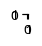

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset



In [2]:
new_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
new_df_78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
new_df_17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df_15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old_df_20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [19]:
tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
tbcr_valid = tbcr.query('partition==0')
tbcr_valid = tbcr_valid[[str(x) for x in tbcr_valid.index]+['peptide','binder','partition','raw_index']]
tbcr_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values

# Check old clustering pruning cnn etc results

In [4]:
get_all_rpauc??

Signature: get_all_rpauc(retentions, purities, input_type=None, name=None)
Docstring: <no docstring>
Source:   
def get_all_rpauc(retentions, purities, input_type=None, name=None):
    total_auc = get_retpur_auc(retentions, purities)
    p60_auc = get_retpur_auc(retentions, purities, min_purity=0.6)
    p70_auc = get_retpur_auc(retentions, purities, min_purity=0.7)

    p60_r40_auc = get_retpur_auc(retentions, purities, min_retention=0.4, min_purity=0.6)
    p70_r35_auc = get_retpur_auc(retentions, purities, min_retention=0.35, min_purity=0.70)
    p70_r50_auc = get_retpur_auc(retentions, purities, min_retention=0.5, min_purity=0.70)
    out = {'input_type': input_type,
           'name': name,
           'total_auc': total_auc,
           'p70_auc': p70_auc,
           'p60_auc': p60_auc,
           'p60_r40_auc': p60_r40_auc,
           'p70_r35_auc': p70_r35_auc,
           'p70_r50_auc': p70_r50_auc}

    return out
File:      ~/Documents/code/tclustr/src/cluster_utils.py
Type:    

In [5]:
test = pd.read_csv('../output/240515_IntervalClustering/ExpData17peps/ExpModel78_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240514_2312_None/ExpModel78_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240514_2312_None_train_results.csv')

In [11]:
test.groupby('input_type').apply(lambda x: get_all_rpauc(x['retention'], x['mean_purity']))

TypeError: <lambda>() got an unexpected keyword argument 'axis'

In [59]:
from src.cluster_utils import get_all_rpauc
from joblib import Parallel, delayed

def rpauc_wrapper(df, input_type):
    tmp = df.query('input_type==@input_type')
    ret = tmp['retention'].values[1:-1]
    pur = tmp['mean_purity'].values[1:-1]
    return get_all_rpauc(ret, pur, input_type, None)
    
def find_best_not_agg(intervals, nm=None):
    tmp = intervals.query('not input_type.str.contains("TBCR") and not input_type.str.startswith("agg") and not input_type.str.contains("tcrdist")')
    results = pd.DataFrame(Parallel(n_jobs=5)(delayed(rpauc_wrapper)(df=tmp, input_type=k) for k in tmp.input_type.unique()))
    best=results.sort_values('p70_r35_auc', ascending=False).head(1).input_type.item()
    return tmp.query('input_type==@best')

def find_agg(fn):
    return pd.read_csv(fn).query('input_type.str.startswith("agg")')


def get_agg_given_dir(maindir, set, idf):
    folders = glob.glob(f'{maindir}/*/*{set}*.csv')
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_agg(x) for x in folders]).assign(identifier=idf)
    
def get_best_given_dir(maindir, set, idf):
    folders = glob.glob(f'{maindir}/*/*{set}*.csv')
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_best_not_agg(pd.read_csv(x)) for x in folders]).assign(identifier=idf)

In [71]:
pd.read_csv('../output/240515_IntervalClustering/ExpData17peps/CNNSmall_ModelFull_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240516_1004_None/CNNVAEModelFull_ExpData17peps_240418_nettcr_expanded_20binders_17pep_POSONLY_240516_1004_None_train_results.csv')

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  threshold  n_cluster  \
0             3996           1.0         1.0    0.00395          1   
1             3997           2.0         2.0    0.00462          1   
2             3998           3.0         3.0    0.00530          1   
3             3999           4.0         4.0    0.00597          6   
4             4000           5.0         5.0    0.00665          6   
...            ...           ...         ...        ...        ...   
6993           495           NaN         NaN    0.70476          2   
6994           496           NaN         NaN    0.70617          2   
6995           497           NaN         NaN    0.70758          2   
6996           498           NaN         NaN    0.70900          2   
6997           499           NaN         NaN    0.71041          1   

      n_singletons  n_cluster_over_70p  mean_purity  min_purity  max_purity  \
0             5866                   1     1.000000    1.000000    1.000000   
1             5866                   1     1.000000    1.000000    1.000000   
2             5866                   1     1.000000    1.000000    1.000000   
3             5856                   6     1.000000    1.000000    1.000000   
4             5856                   6     1.000000    1.000000    1.000000   
...            ...                 ...          ...         ...         ...   
6993             0                   0     0.412828    0.158990    0.666667   
6994             0                   0     0.412828    0.158990    0.666667   
6995             0                   0     0.412828    0.158990    0.666667   
6996             0                   0     0.412828    0.158990    0.666667   
6997             0                   0     0.158828    0.158828    0.158828   

      ...  mean_cluster_size  min_cluster_size  max_cluster_size  silhouette  \
0     ...                2.0               2.0               2.0         0.0   
1     ...                2.0               2.0               2.0         0.0   
2     ...                2.0               2.0               2.0         0.0   
3     ...                2.0               2.0               2.0         0.0   
4     ...                2.0               2.0               2.0         0.0   
...   ...                ...               ...               ...         ...   
6993  ...             2934.0               6.0            5862.0         0.0   
6994  ...             2934.0               6.0            5862.0         0.0   
6995  ...             2934.0               6.0            5862.0         0.0   
6996  ...             2934.0               6.0            5862.0         0.0   
6997  ...             5868.0            5868.0            5868.0         NaN   

      ch_index   db_index       ARI  retention  \
0     2.678800   4.307425  0.000001   0.000341   
1     2.678800   4.307425  0.000001   0.000341   
2     2.678800   4.307425  0.000001   0.000341   
3     0.982027  32.592736  0.000007   0.002045   
4     0.982027  32.592736  0.000007   0.002045   
...        ...        ...       ...        ...   
6993  1.402419   3.648338       NaN   1.000000   
6994  1.402419   3.648338       NaN   1.000000   
6995  1.402419   3.648338       NaN   1.000000   
6996  1.402419   3.648338       NaN   1.000000   
6997       NaN        NaN       NaN   1.000000   

                             input_type             db  
0                             TBCRalign  ExpData17peps  
1                             TBCRalign  ExpData17peps  
2                             TBCRalign  ExpData17peps  
3                             TBCRalign  ExpData17peps  
4                             TBCRalign  ExpData17peps  
...                                 ...            ...  
6993  agg_CNNVAEModelFull_ExpData17peps            NaN  
6994  agg_CNNVAEModelFull_ExpData17peps            NaN  
6995  agg_CNNVAEModelFull_ExpData17peps            NaN  
6996  agg_CNNVAEModelFull_ExpData17peps            NaN  
6997  agg_CNNVAEModelFull_E

In [50]:
'ExpModelFull_ExpDataTop78_poch_10000'.split('_ExpDataTop78_')[0]

'ExpModelFull'

In [68]:
prune_results['ExpData17peps']['train'].input_type.unique()

array(['TBCRalign', 'tcrdist3', 'CNNVAEModelFull', 'ExpModelFull',
       'ExpModelRed', 'ExpModel17', 'ExpModel78'], dtype=object)

In [77]:
prune_results['ExpDataTop78']['train'].input_type.unique()

array(['TBCRalign', 'tcrdist3', 'ExpModelFull', 'ExpModelRed',
       'ExpModel17', 'CNNVAE_LARGE', 'CNNVAESmallerFull', 'ExpModel78'],
      dtype=object)

In [82]:
small78 = pd.read_csv('../output/240515_IntervalClustering/ExpDataTop78/CNNSmall_ModelFull_ExpDataTop78_240507_nettcr_exp_pruned_noswap_78peps_240516_1133_None/CNNVAESmallerFull_ExpDataTop78_240507_nettcr_exp_pruned_noswap_78peps_240516_1133_None_valid_results.csv')
LARGE78 = pd.read_csv('../output/240515_IntervalClustering/ExpDataTop78/CNNLARGE_ModelFull_ExpDataTop78_240507_nettcr_exp_pruned_noswap_78peps_240516_1003_None/CNNVAEModelFull_ExpDataTop78_240507_nettcr_exp_pruned_noswap_78peps_240516_1003_None_valid_results.csv')

In [85]:
LARGE78.query('input_type.str.contains("agg")')

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  threshold  n_cluster  \
6500             0           NaN         NaN    0.04190          0   
6501             1           NaN         NaN    0.04320          1   
6502             2           NaN         NaN    0.04451          1   
6503             3           NaN         NaN    0.04581          1   
6504             4           NaN         NaN    0.04712          1   
...            ...           ...         ...        ...        ...   
6995           495           NaN         NaN    0.68760          1   
6996           496           NaN         NaN    0.68891          1   
6997           497           NaN         NaN    0.69021          1   
6998           498           NaN         NaN    0.69152          1   
6999           499           NaN         NaN    0.69282          1   

      n_singletons  n_cluster_over_70p  mean_purity  min_purity  max_purity  \
6500          1394                   0          NaN         NaN         NaN   
6501          1392                   1     1.000000    1.000000    1.000000   
6502          1392                   1     1.000000    1.000000    1.000000   
6503          1392                   1     1.000000    1.000000    1.000000   
6504          1392                   1     1.000000    1.000000    1.000000   
...            ...                 ...          ...         ...         ...   
6995             1                   0     0.166547    0.166547    0.166547   
6996             1                   0     0.166547    0.166547    0.166547   
6997             1                   0     0.166547    0.166547    0.166547   
6998             1                   0     0.166547    0.166547    0.166547   
6999             0                   0     0.167145    0.167145    0.167145   

      ...  mean_cluster_size  min_cluster_size  max_cluster_size  silhouette  \
6500  ...                NaN               NaN               NaN         NaN   
6501  ...                2.0               2.0               2.0         0.0   
6502  ...                2.0               2.0               2.0         0.0   
6503  ...                2.0               2.0               2.0         0.0   
6504  ...                2.0               2.0               2.0         0.0   
...   ...                ...               ...               ...         ...   
6995  ...             1393.0            1393.0            1393.0         0.0   
6996  ...             1393.0            1393.0            1393.0         0.0   
6997  ...             1393.0            1393.0            1393.0         0.0   
6998  ...             1393.0            1393.0            1393.0         0.0   
6999  ...             1394.0            1394.0            1394.0         NaN   

      ch_index  db_index  ARI  retention                     input_type   db  
6500       NaN       NaN  NaN   0.000000  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6501  0.247656  6.855383  NaN   0.001435  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6502  0.247656  6.855383  NaN   0.001435  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6503  0.247656  6.855383  NaN   0.001435  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6504  0.247656  6.855383  NaN   0.001435  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
...        ...       ...  ...        ...                            ...  ...  
6995  2.899938  0.509748  NaN   0.999283  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6996  2.899938  0.509748  NaN   0.999283  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6997  2.899938  0.509748  NaN   0.999283  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6998  2.899938  0.509748  NaN   0.999283  agg_CNNVAE_LARGE_ExpDataTop78  NaN  
6999       NaN       NaN  NaN   1.000000  agg_CNNVAE_LARGE_ExpDataTop78  NaN  

[500 rows x 23 columns]

In [84]:
small78.query('input_type.str.contains("agg")')

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  threshold  n_cluster  \
6500             0           NaN         NaN    0.04190          0   
6501             1           NaN         NaN    0.04320          1   
6502             2           NaN         NaN    0.04451          1   
6503             3           NaN         NaN    0.04581          1   
6504             4           NaN         NaN    0.04712          1   
...            ...           ...         ...        ...        ...   
6995           495           NaN         NaN    0.68760          1   
6996           496           NaN         NaN    0.68891          1   
6997           497           NaN         NaN    0.69021          1   
6998           498           NaN         NaN    0.69152          1   
6999           499           NaN         NaN    0.69282          1   

      n_singletons  n_cluster_over_70p  mean_purity  min_purity  max_purity  \
6500          1394                   0          NaN         NaN         NaN   
6501          1392                   1     1.000000    1.000000    1.000000   
6502          1392                   1     1.000000    1.000000    1.000000   
6503          1392                   1     1.000000    1.000000    1.000000   
6504          1392                   1     1.000000    1.000000    1.000000   
...            ...                 ...          ...         ...         ...   
6995             1                   0     0.166547    0.166547    0.166547   
6996             1                   0     0.166547    0.166547    0.166547   
6997             1                   0     0.166547    0.166547    0.166547   
6998             1                   0     0.166547    0.166547    0.166547   
6999             0                   0     0.167145    0.167145    0.167145   

      ...  mean_cluster_size  min_cluster_size  max_cluster_size  silhouette  \
6500  ...                NaN               NaN               NaN         NaN   
6501  ...                2.0               2.0               2.0         0.0   
6502  ...                2.0               2.0               2.0         0.0   
6503  ...                2.0               2.0               2.0         0.0   
6504  ...                2.0               2.0               2.0         0.0   
...   ...                ...               ...               ...         ...   
6995  ...             1393.0            1393.0            1393.0         0.0   
6996  ...             1393.0            1393.0            1393.0         0.0   
6997  ...             1393.0            1393.0            1393.0         0.0   
6998  ...             1393.0            1393.0            1393.0         0.0   
6999  ...             1394.0            1394.0            1394.0         NaN   

      ch_index  db_index  ARI  retention                          input_type  \
6500       NaN       NaN  NaN   0.000000  agg_CNNVAESmallerFull_ExpDataTop78   
6501  0.304049  5.607553  NaN   0.001435  agg_CNNVAESmallerFull_ExpDataTop78   
6502  0.304049  5.607553  NaN   0.001435  agg_CNNVAESmallerFull_ExpDataTop78   
6503  0.304049  5.607553  NaN   0.001435  agg_CNNVAESmallerFull_ExpDataTop78   
6504  0.304049  5.607553  NaN   0.001435  agg_CNNVAESmallerFull_ExpDataTop78   
...        ...       ...  ...        ...                                 ...   
6995  0.242639  1.761160  NaN   0.999283  agg_CNNVAESmallerFull_ExpDataTop78   
6996  0.242639  1.761160  NaN   0.999283  agg_CNNVAESmallerFull_ExpDataTop78   
6997  0.242639  1.761160  NaN   0.999283  agg_CNNVAESmallerFull_ExpDataTop78   
6998  0.242639  1.761160  NaN   0.999283  agg_CNNVAESmallerFull_ExpDataTop78   
6999       NaN       NaN  NaN   1.000000  agg_CNNVAESmallerFull_ExpDataTop78   

       db  
6500  NaN  
6501  NaN  
6502  NaN  
6503  NaN  
6504  NaN  
...   ...  
6995  NaN  
6996  NaN  
6997  NaN  
6998  NaN  
6999  NaN  

[500 rows x 23 columns]

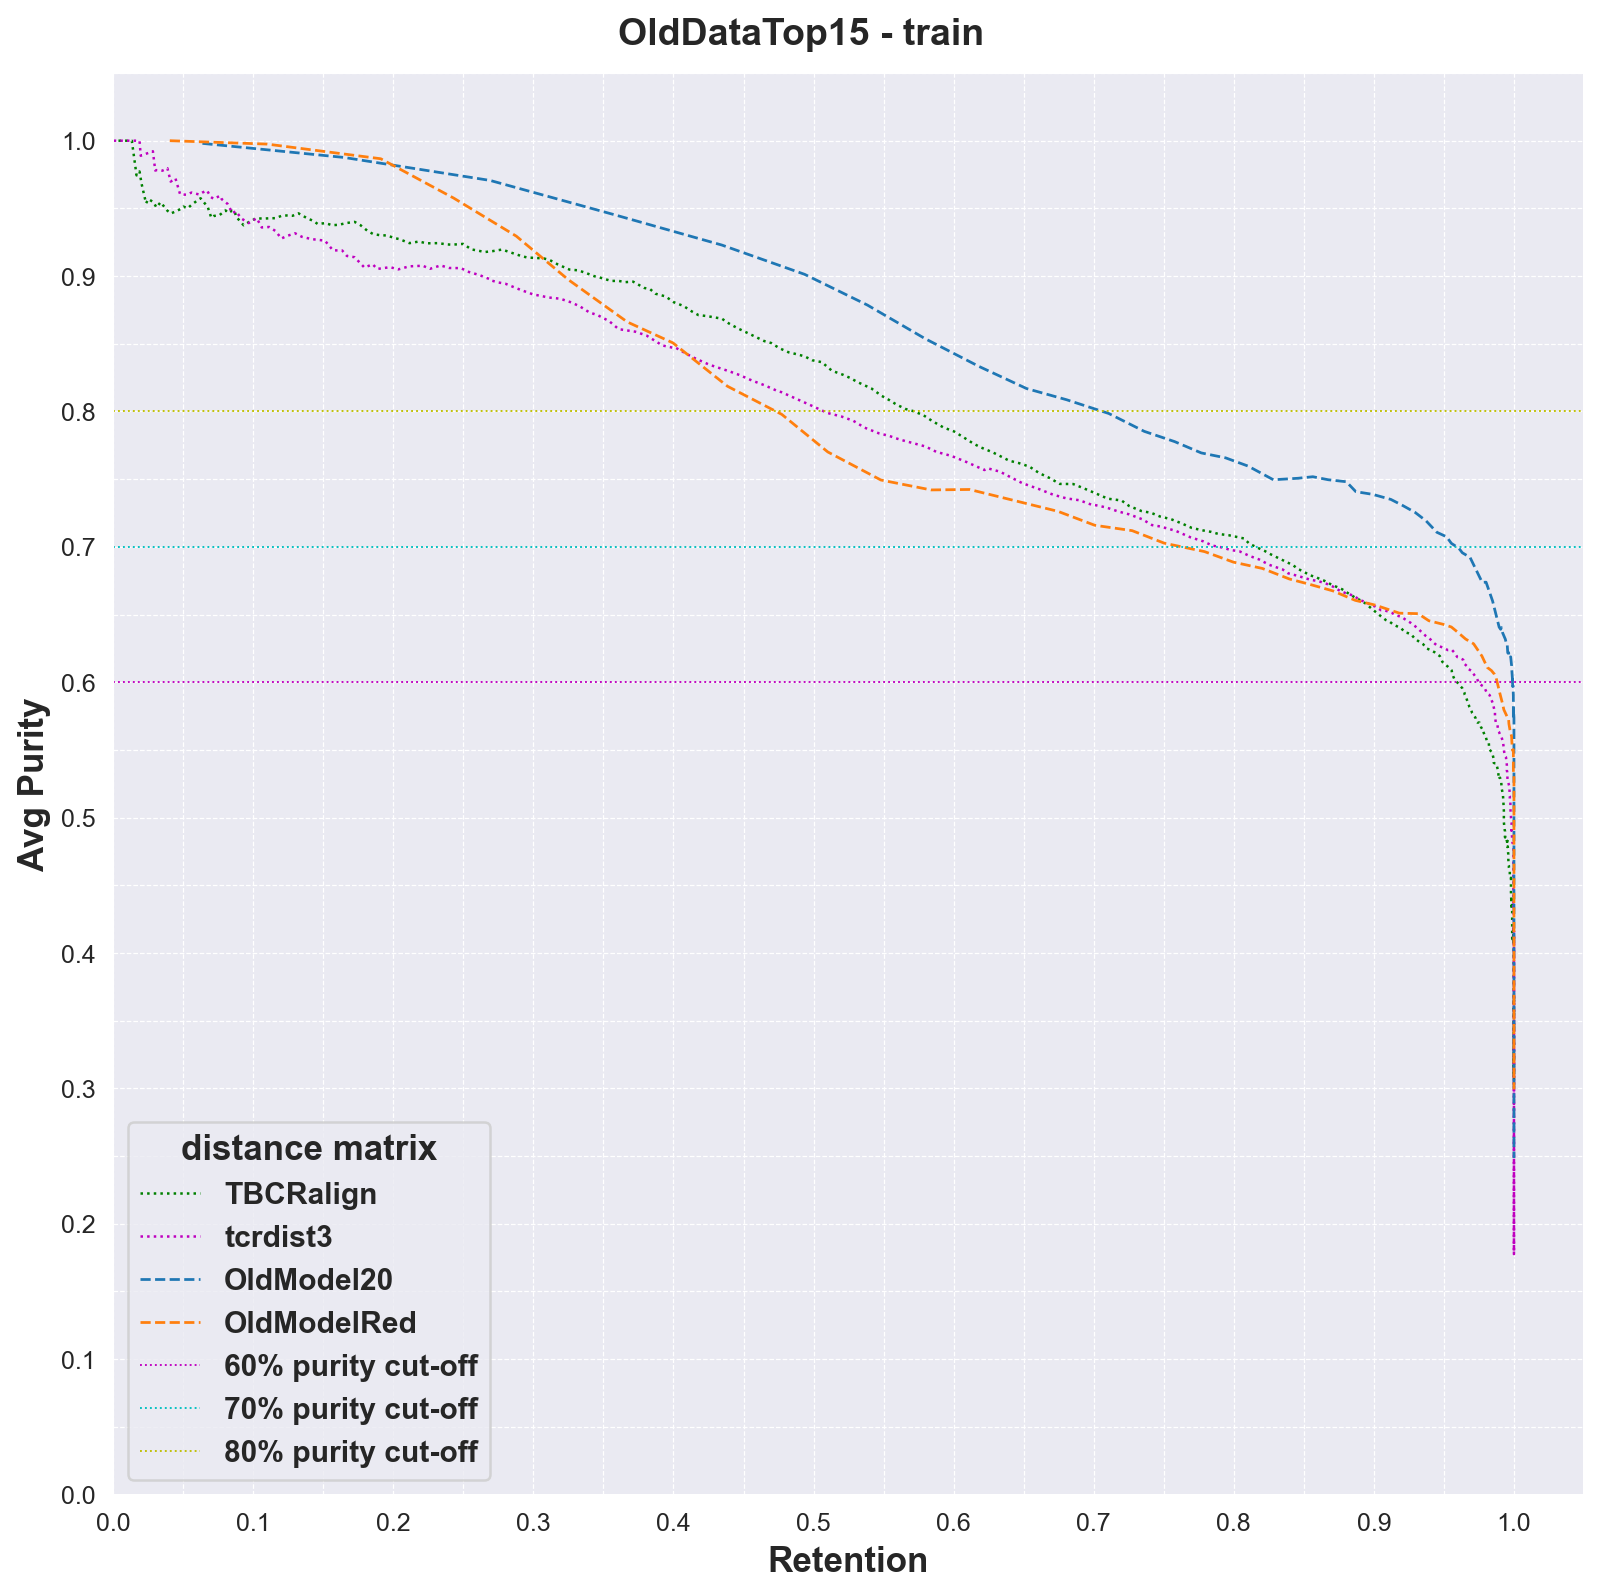

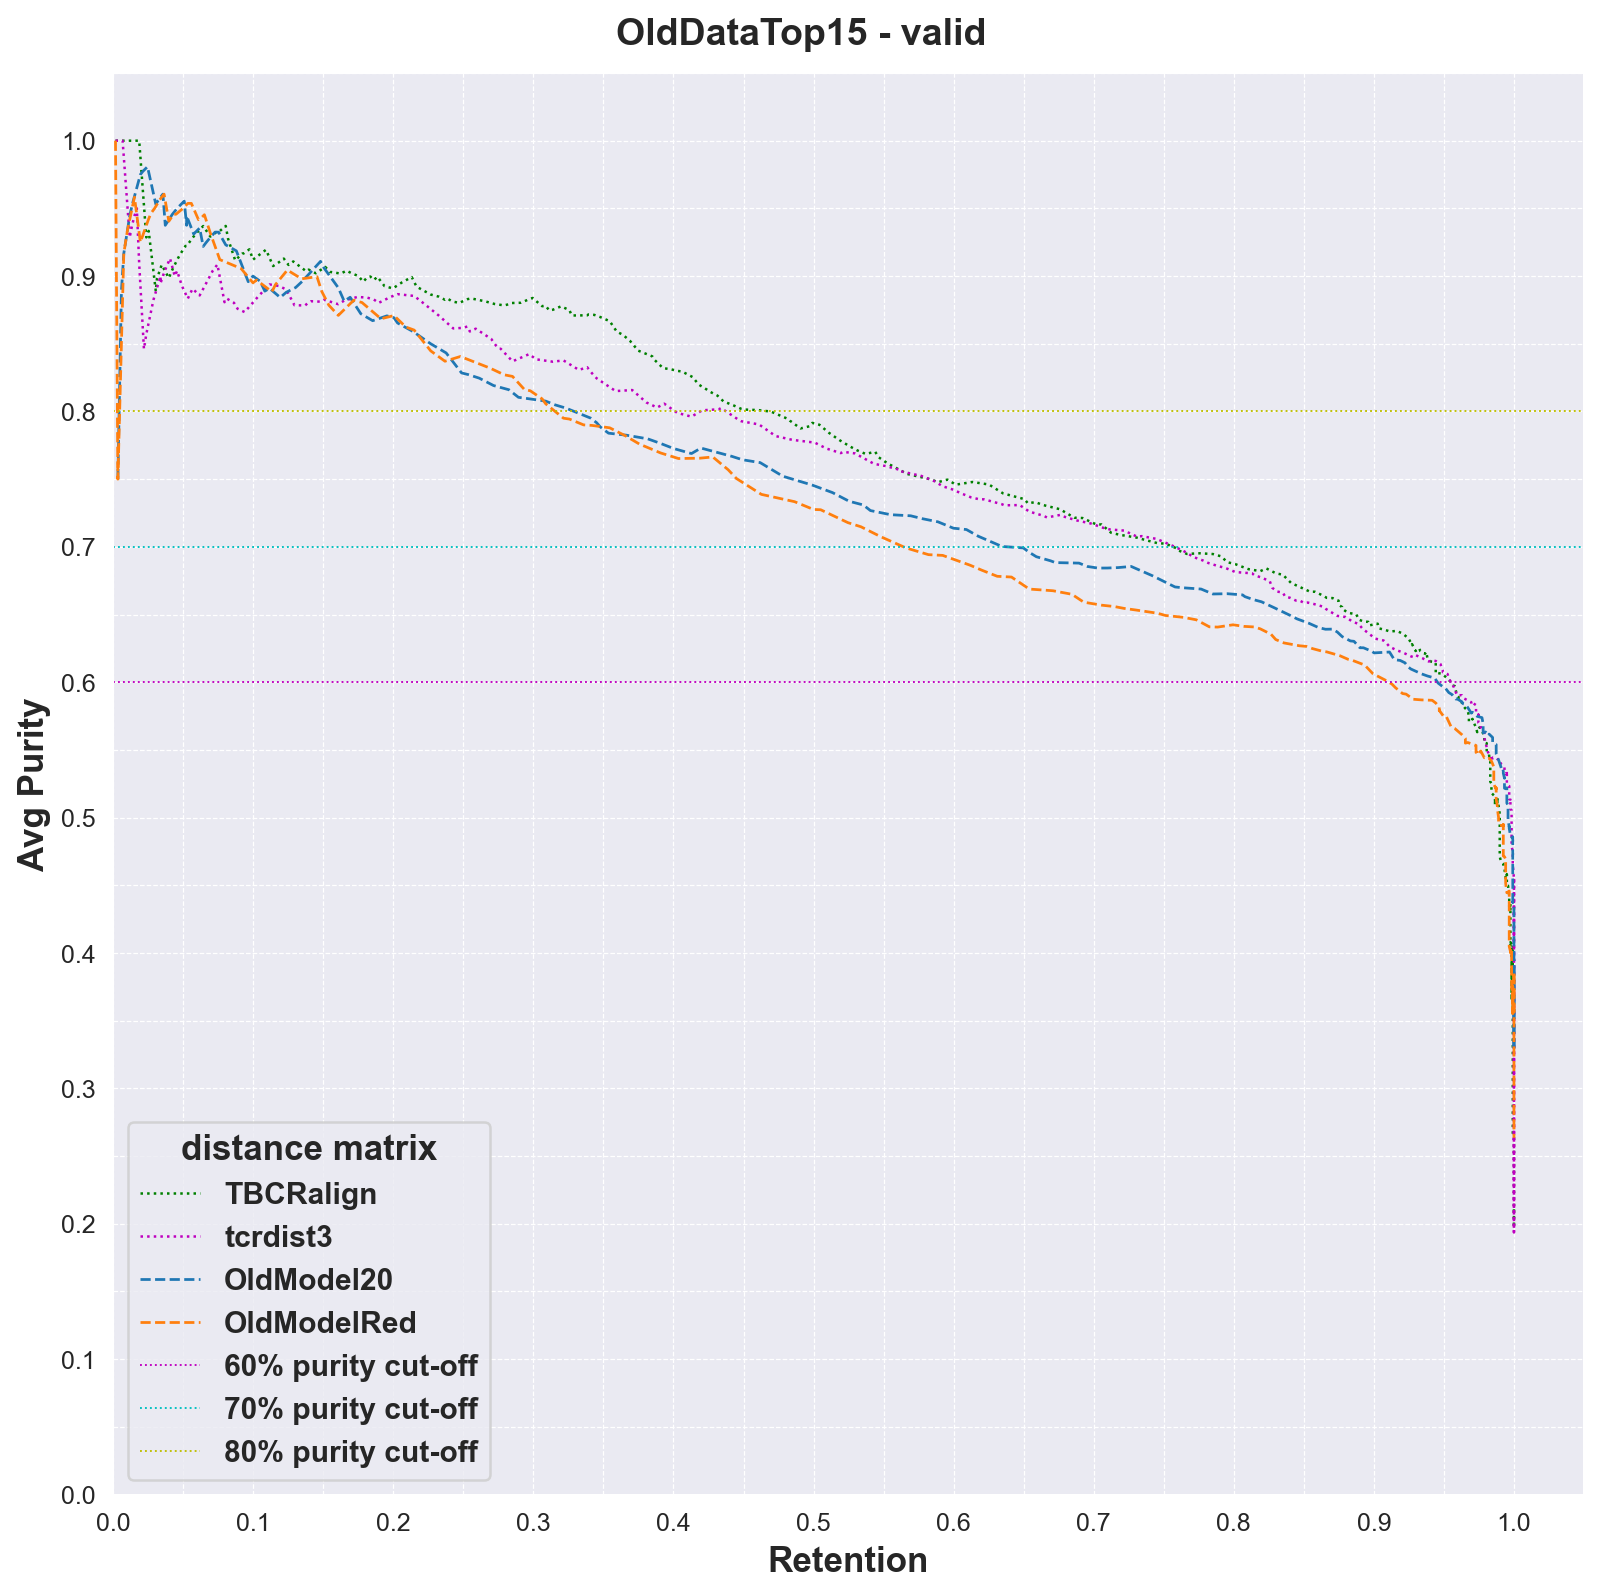

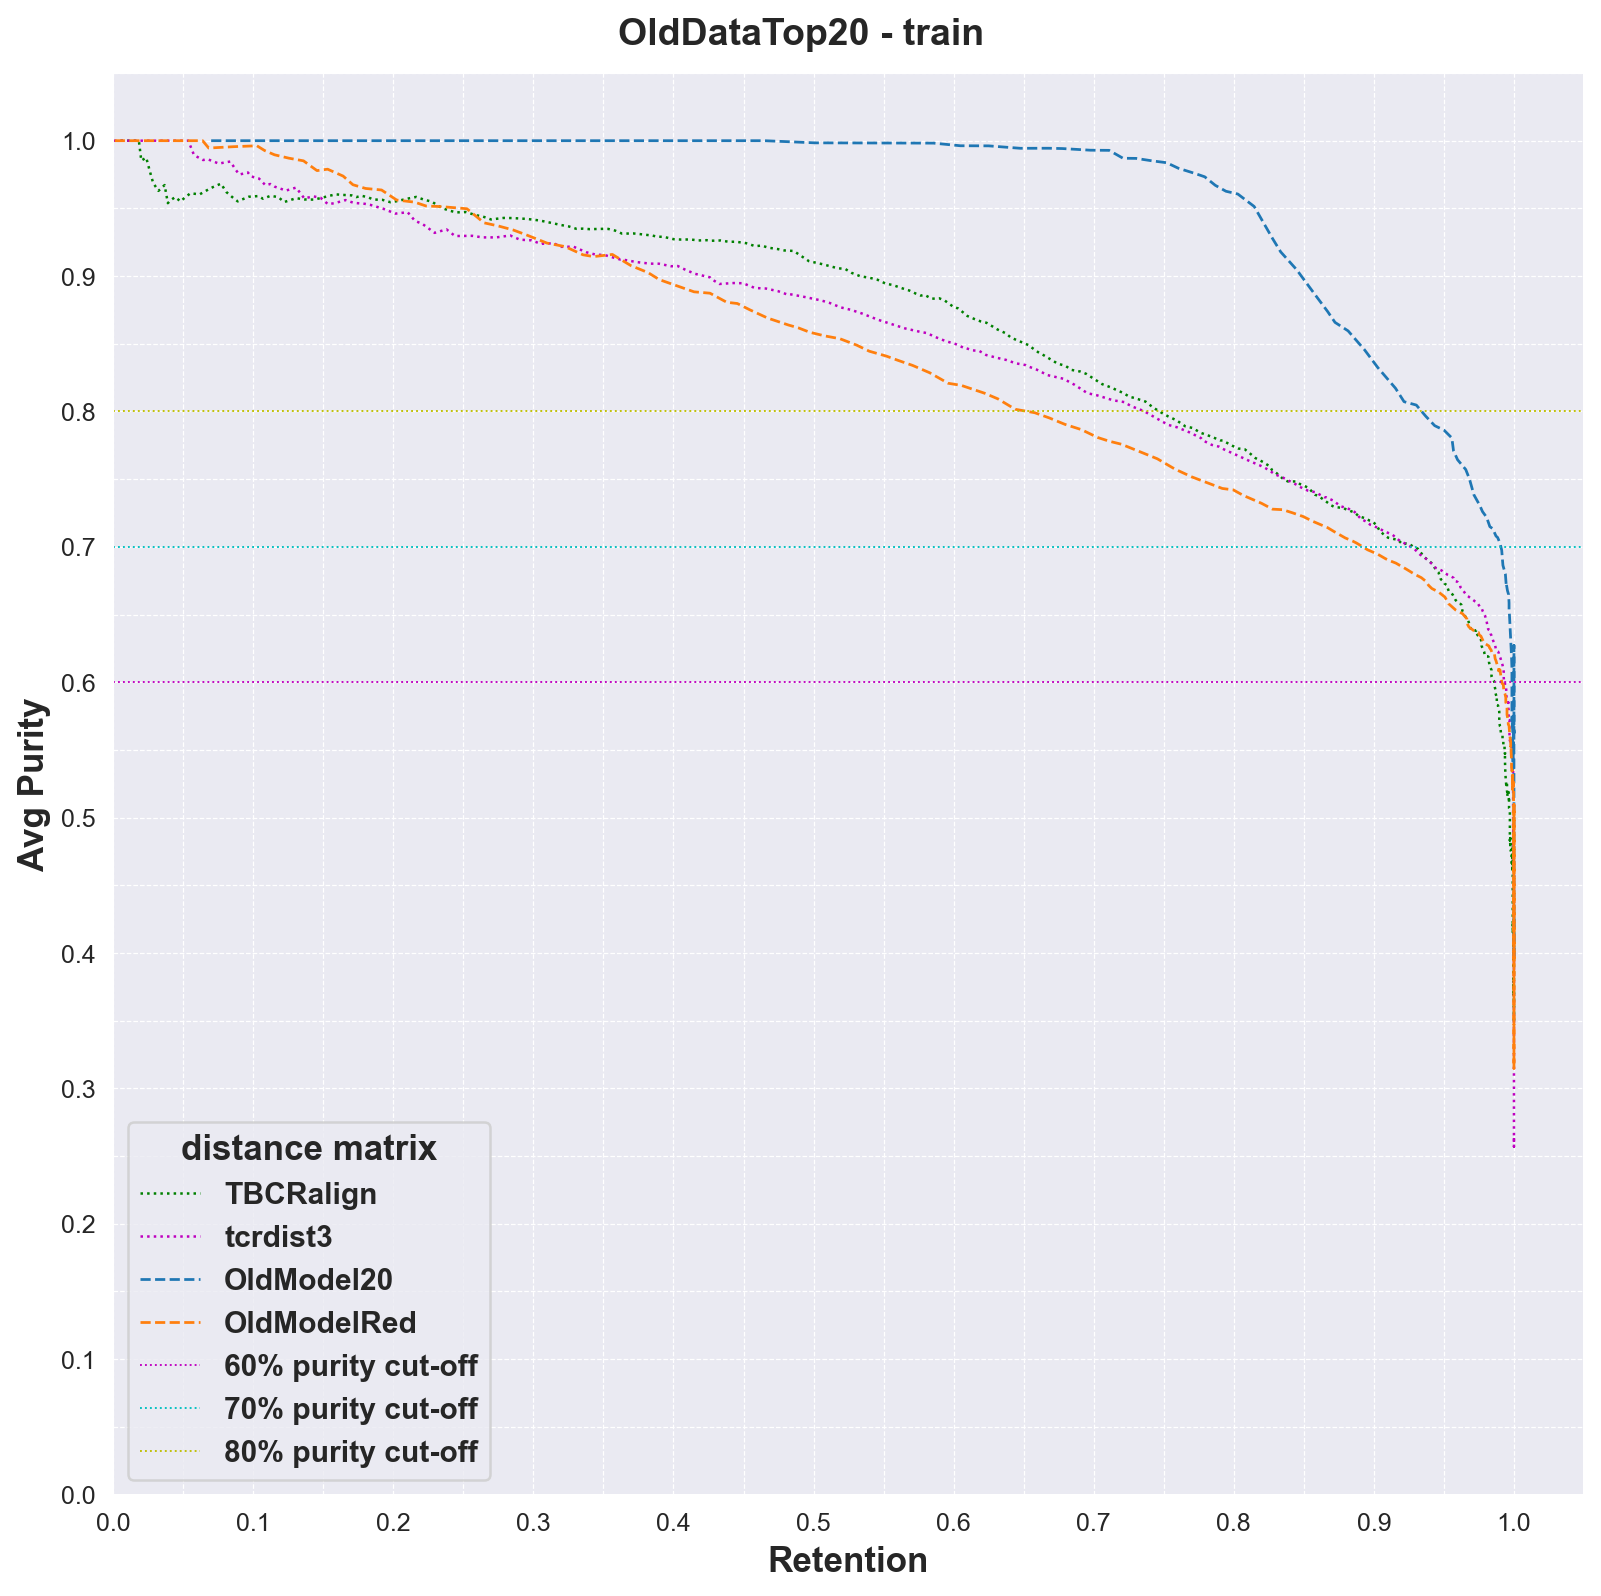

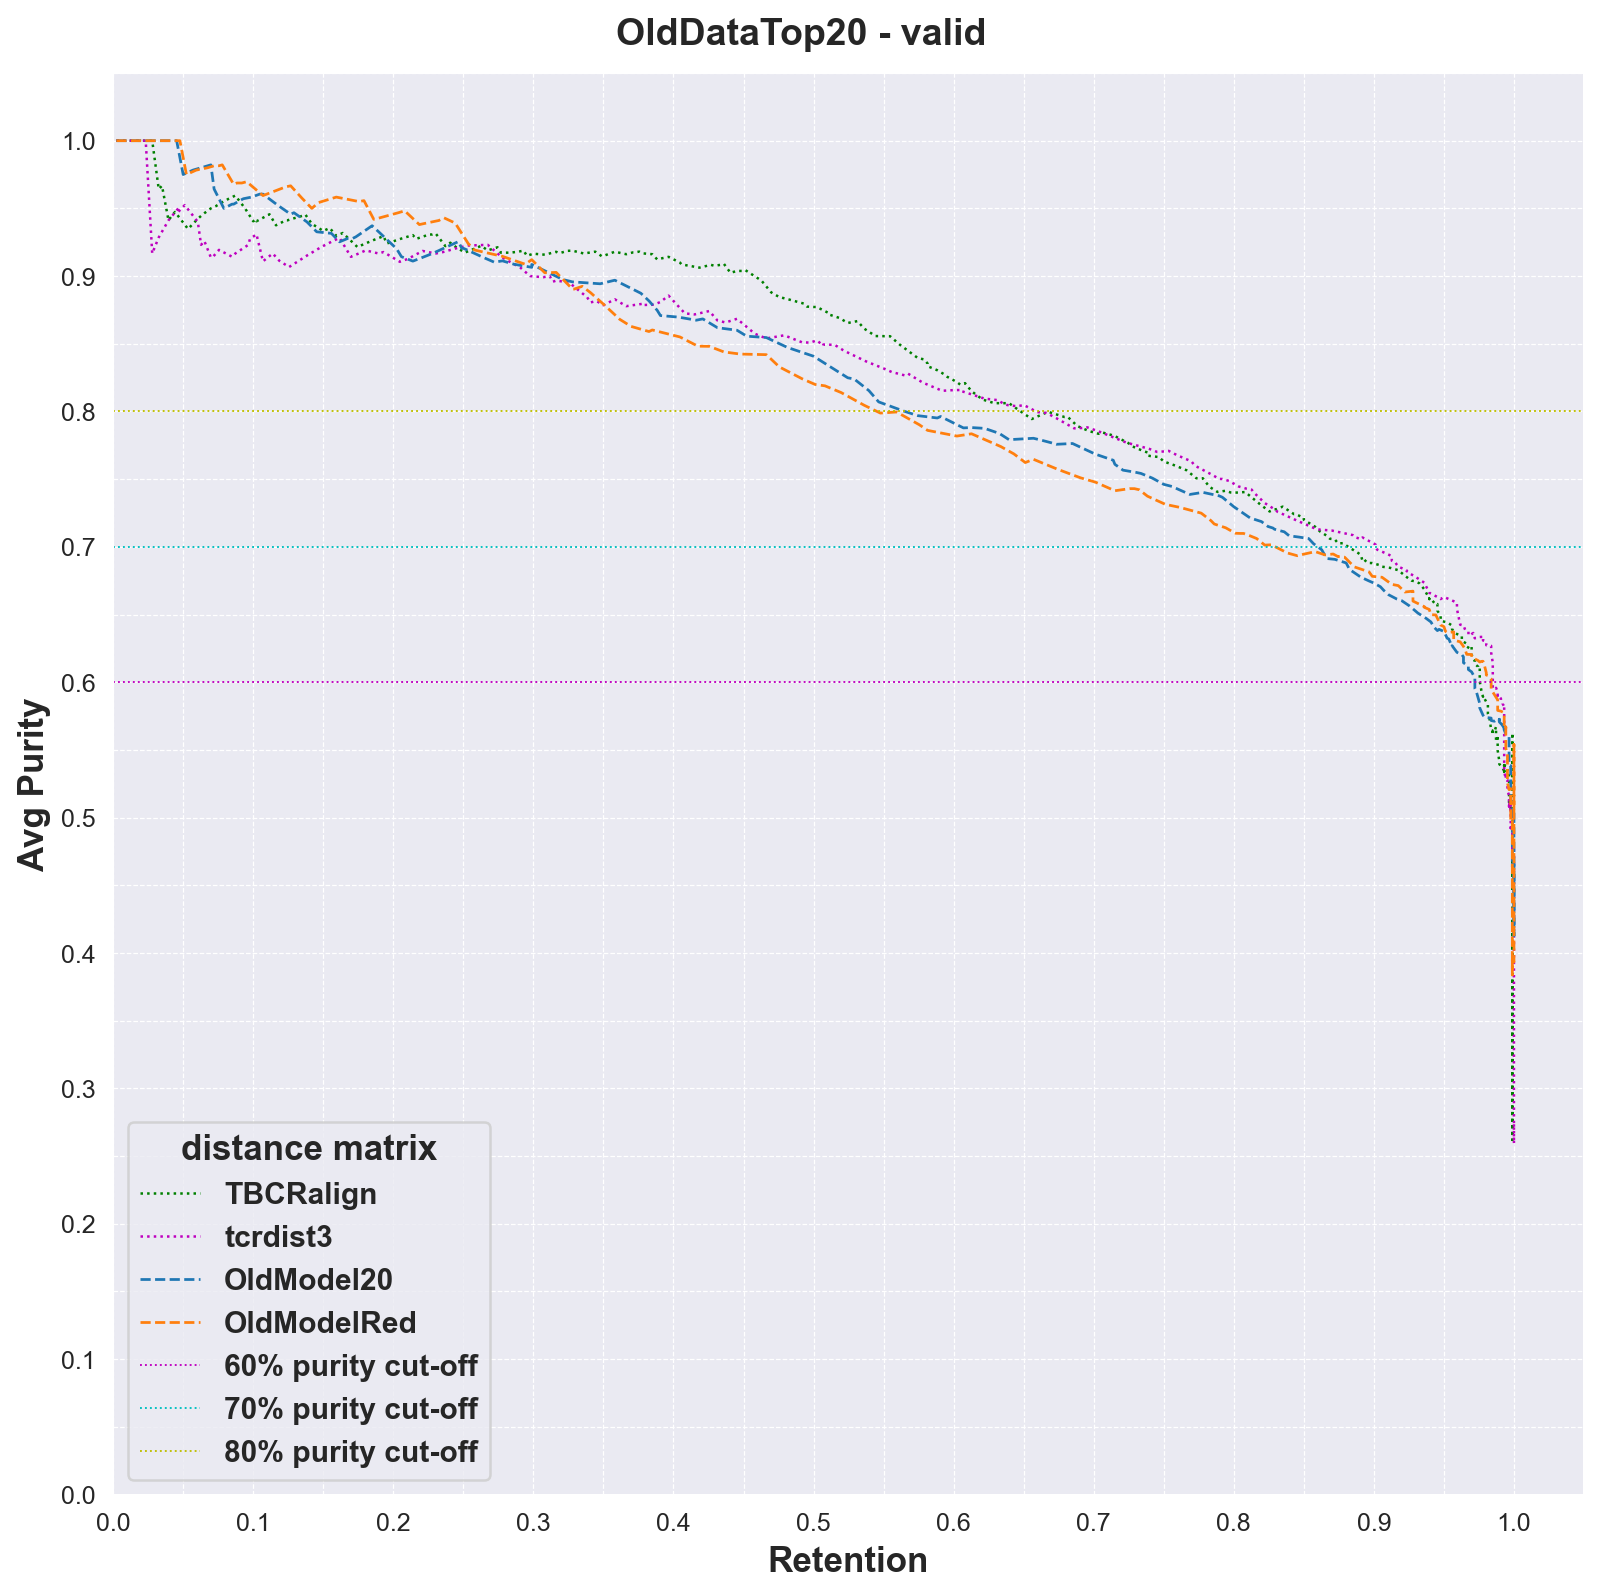

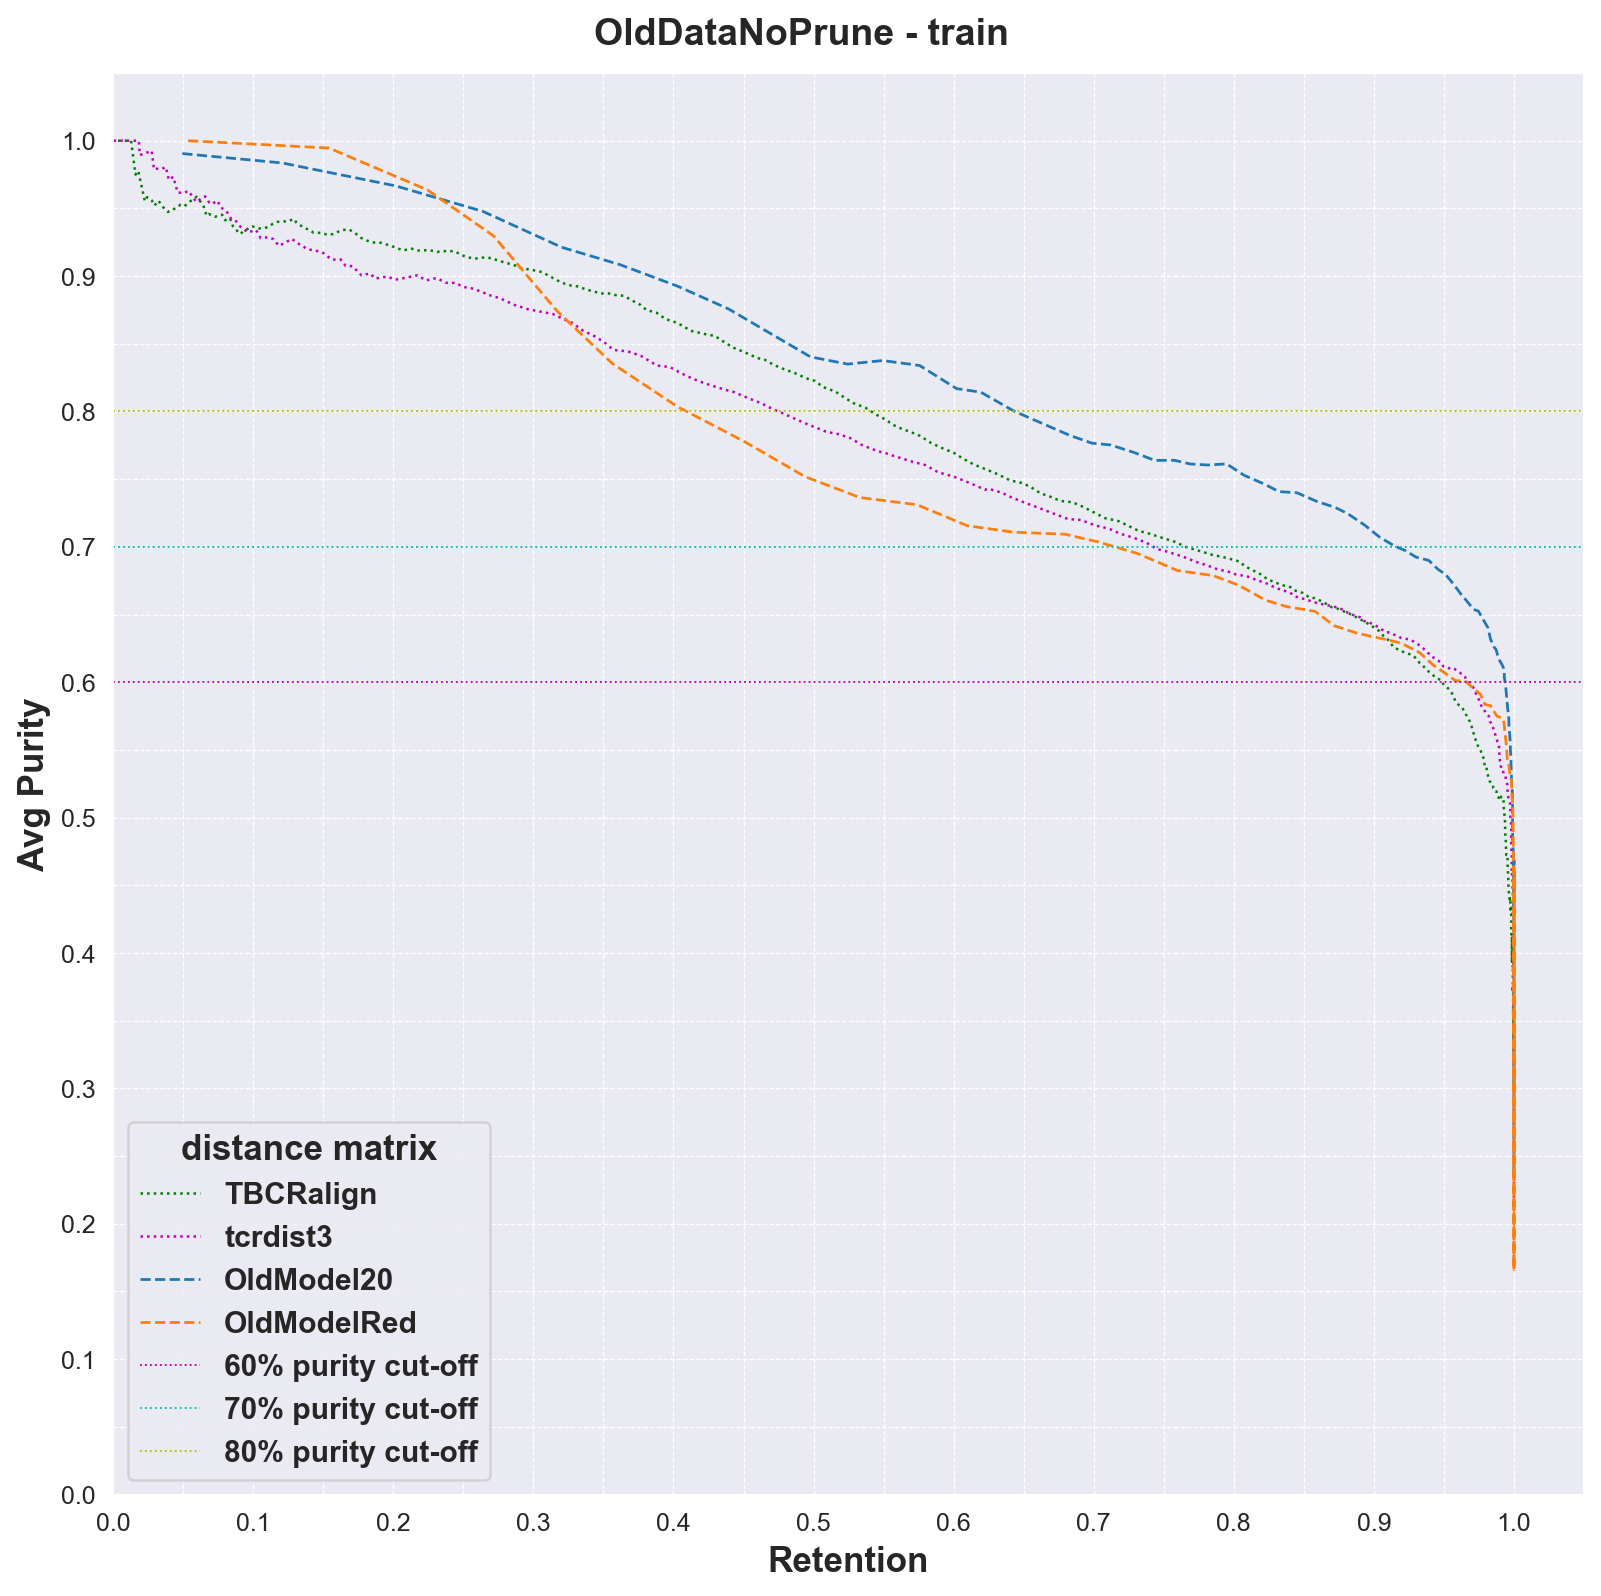

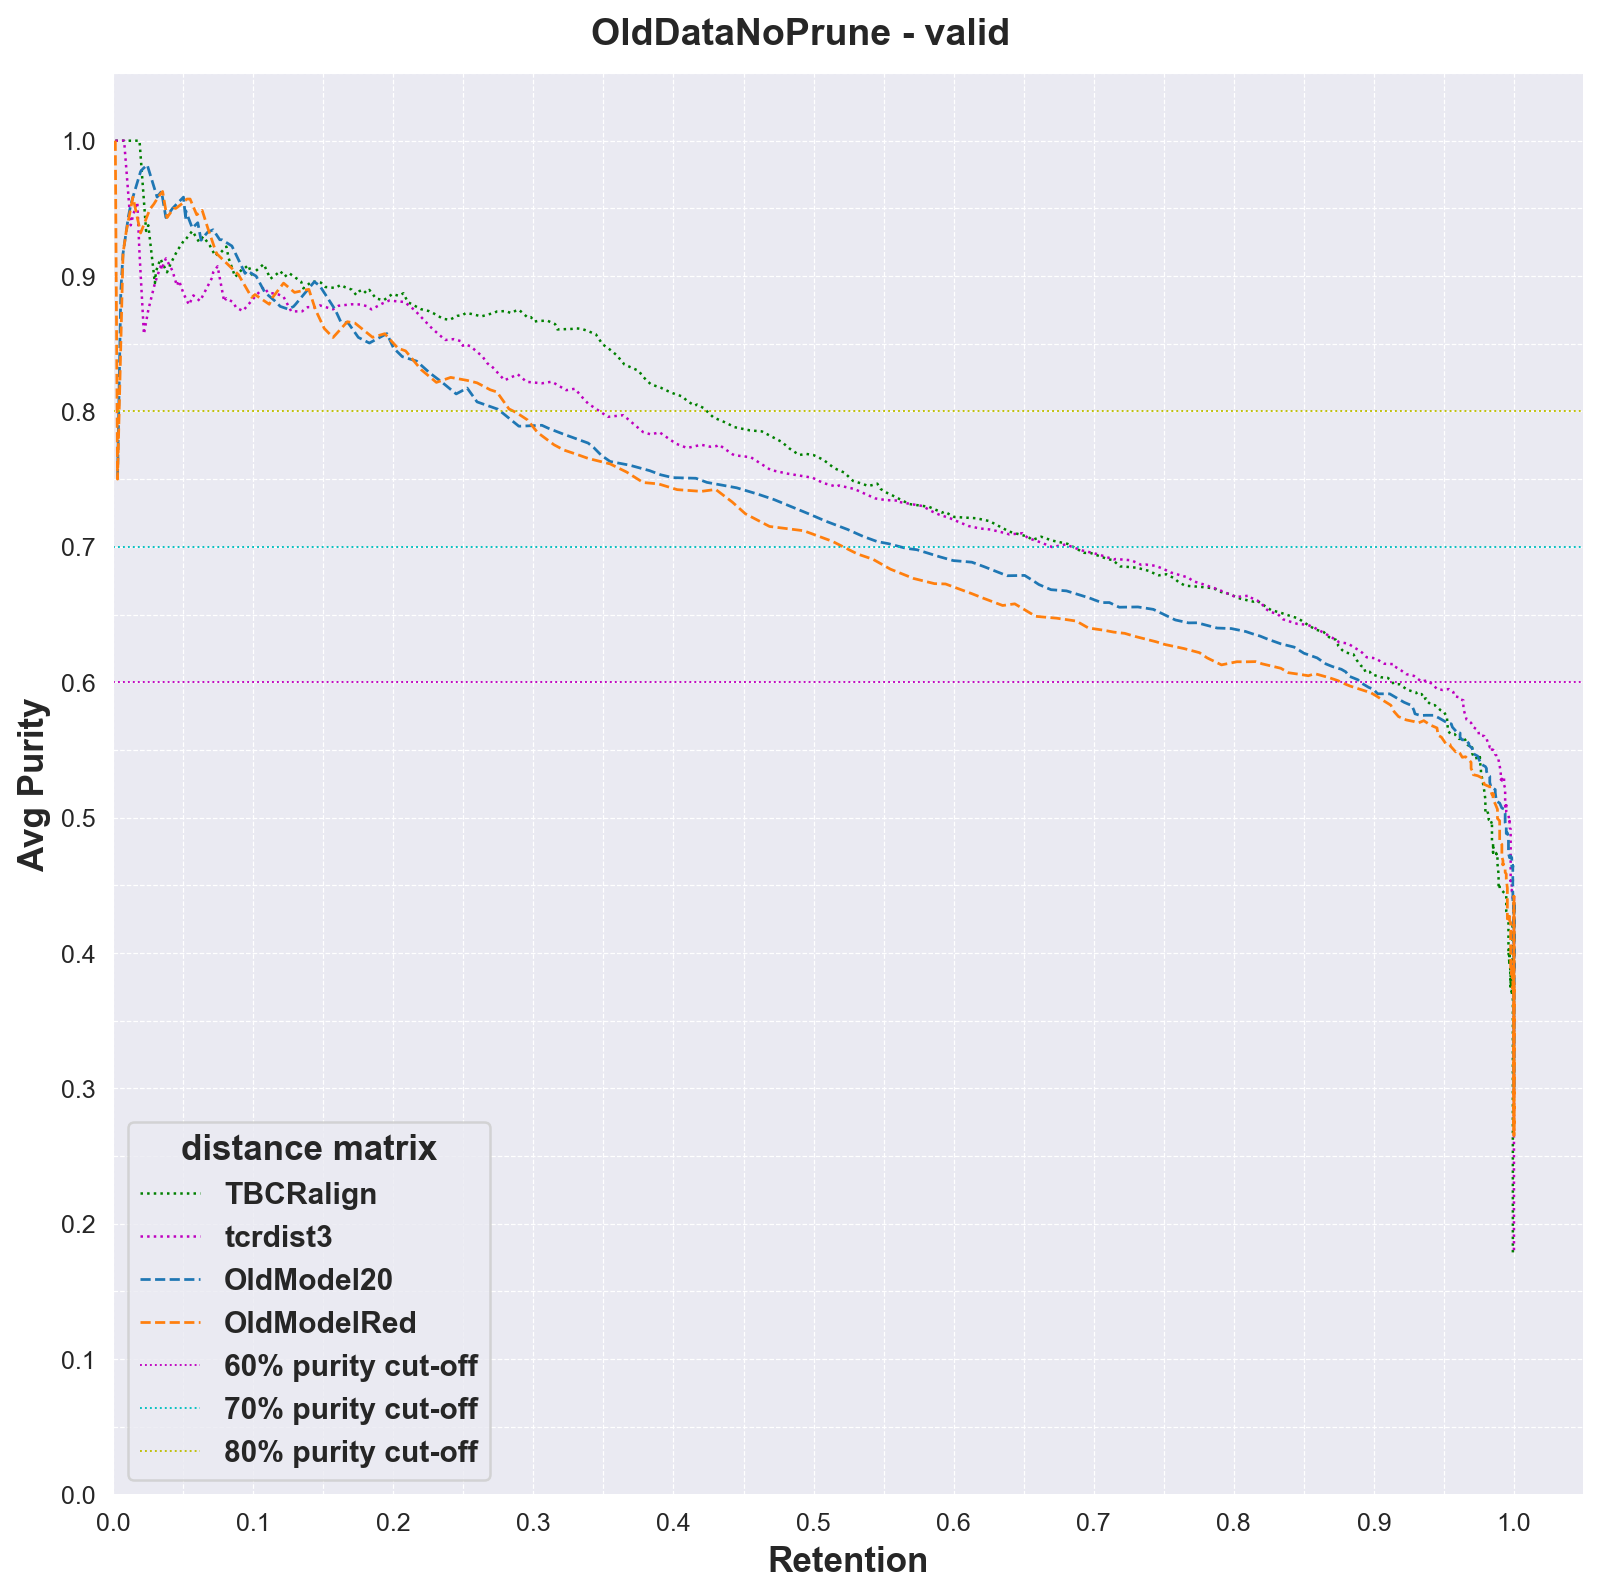

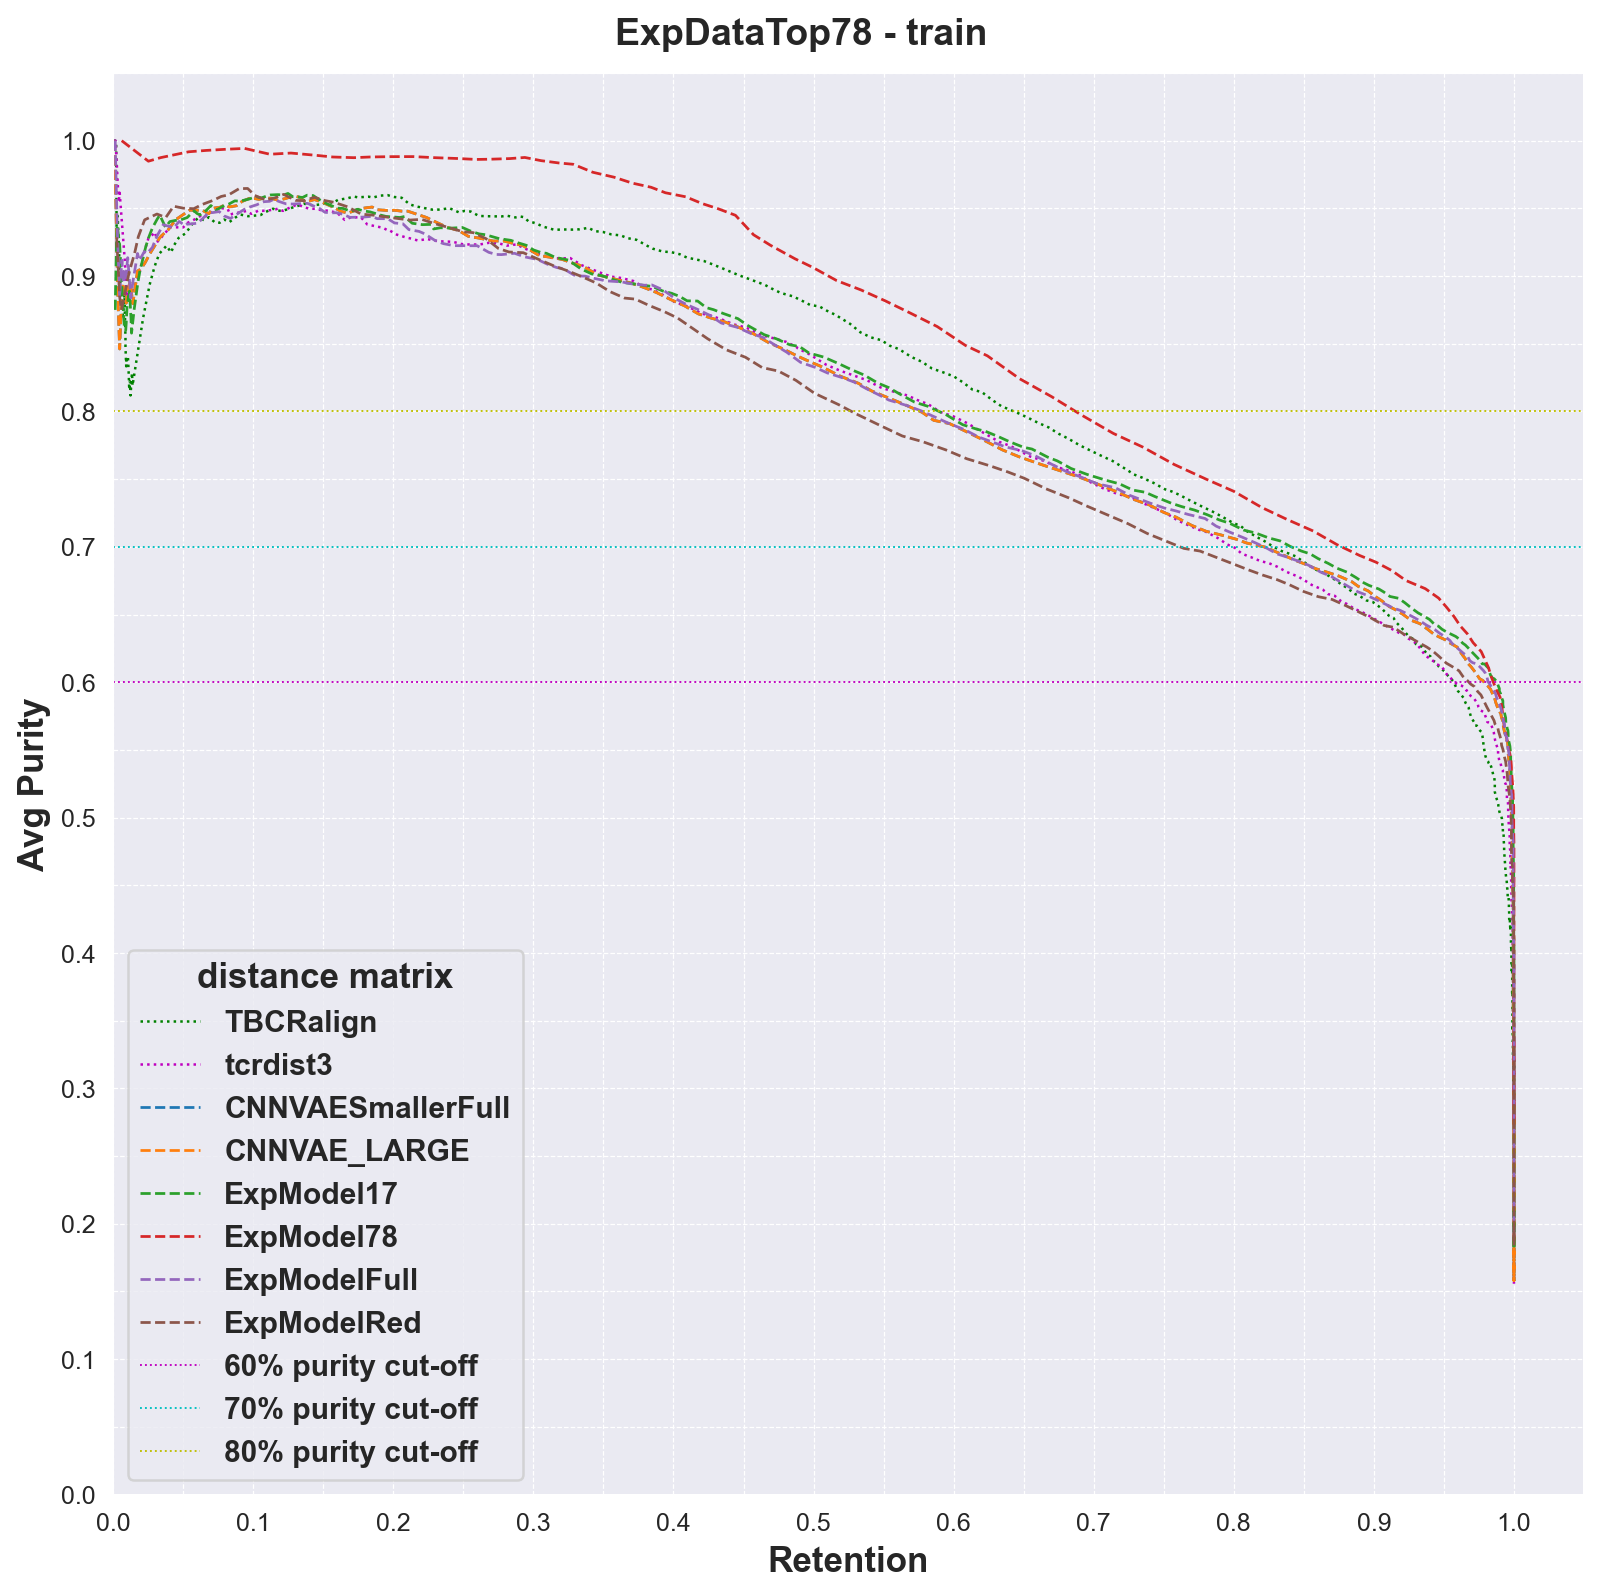

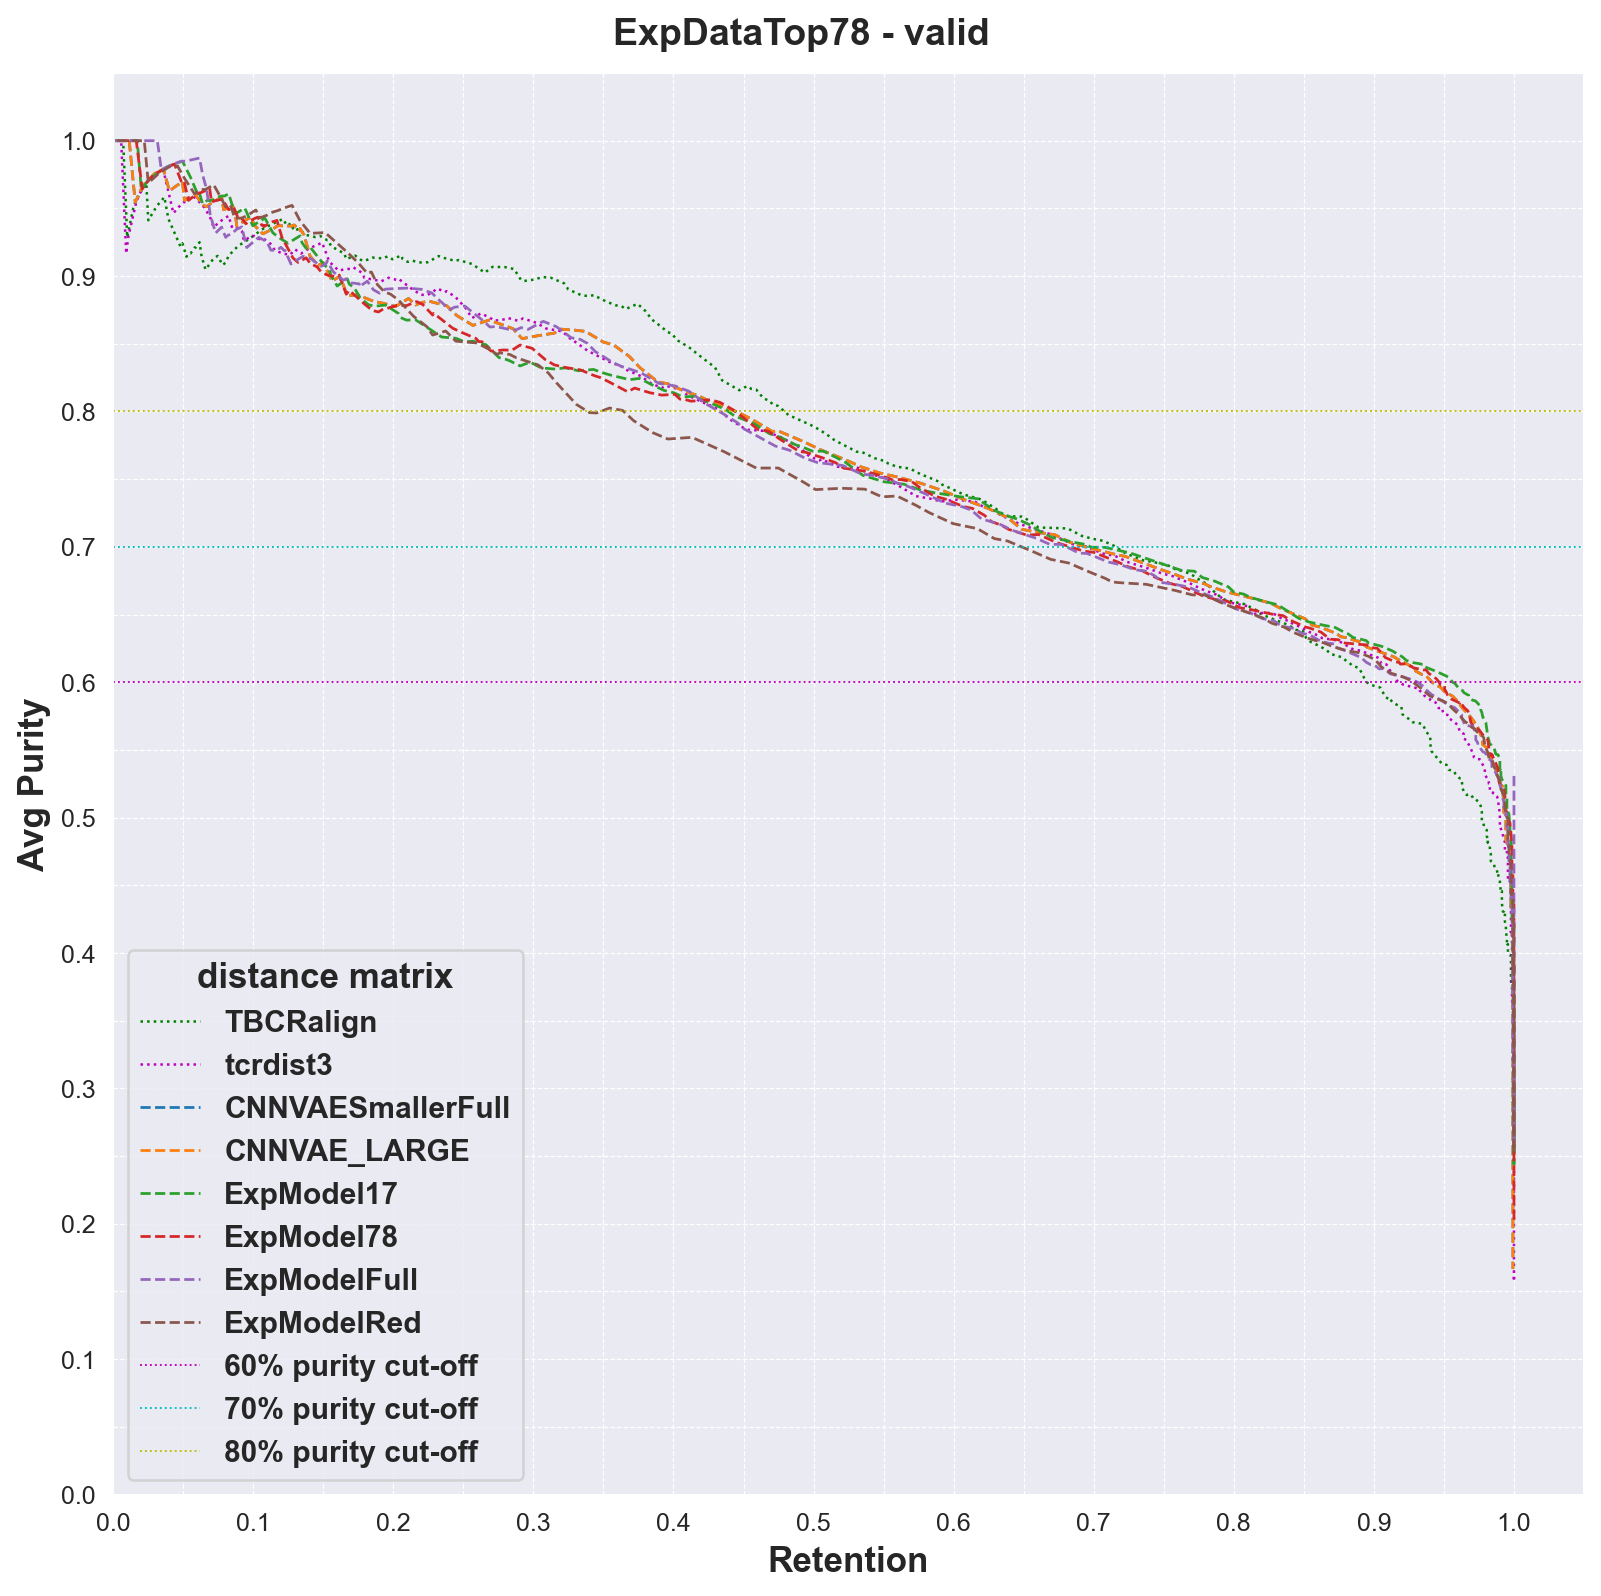

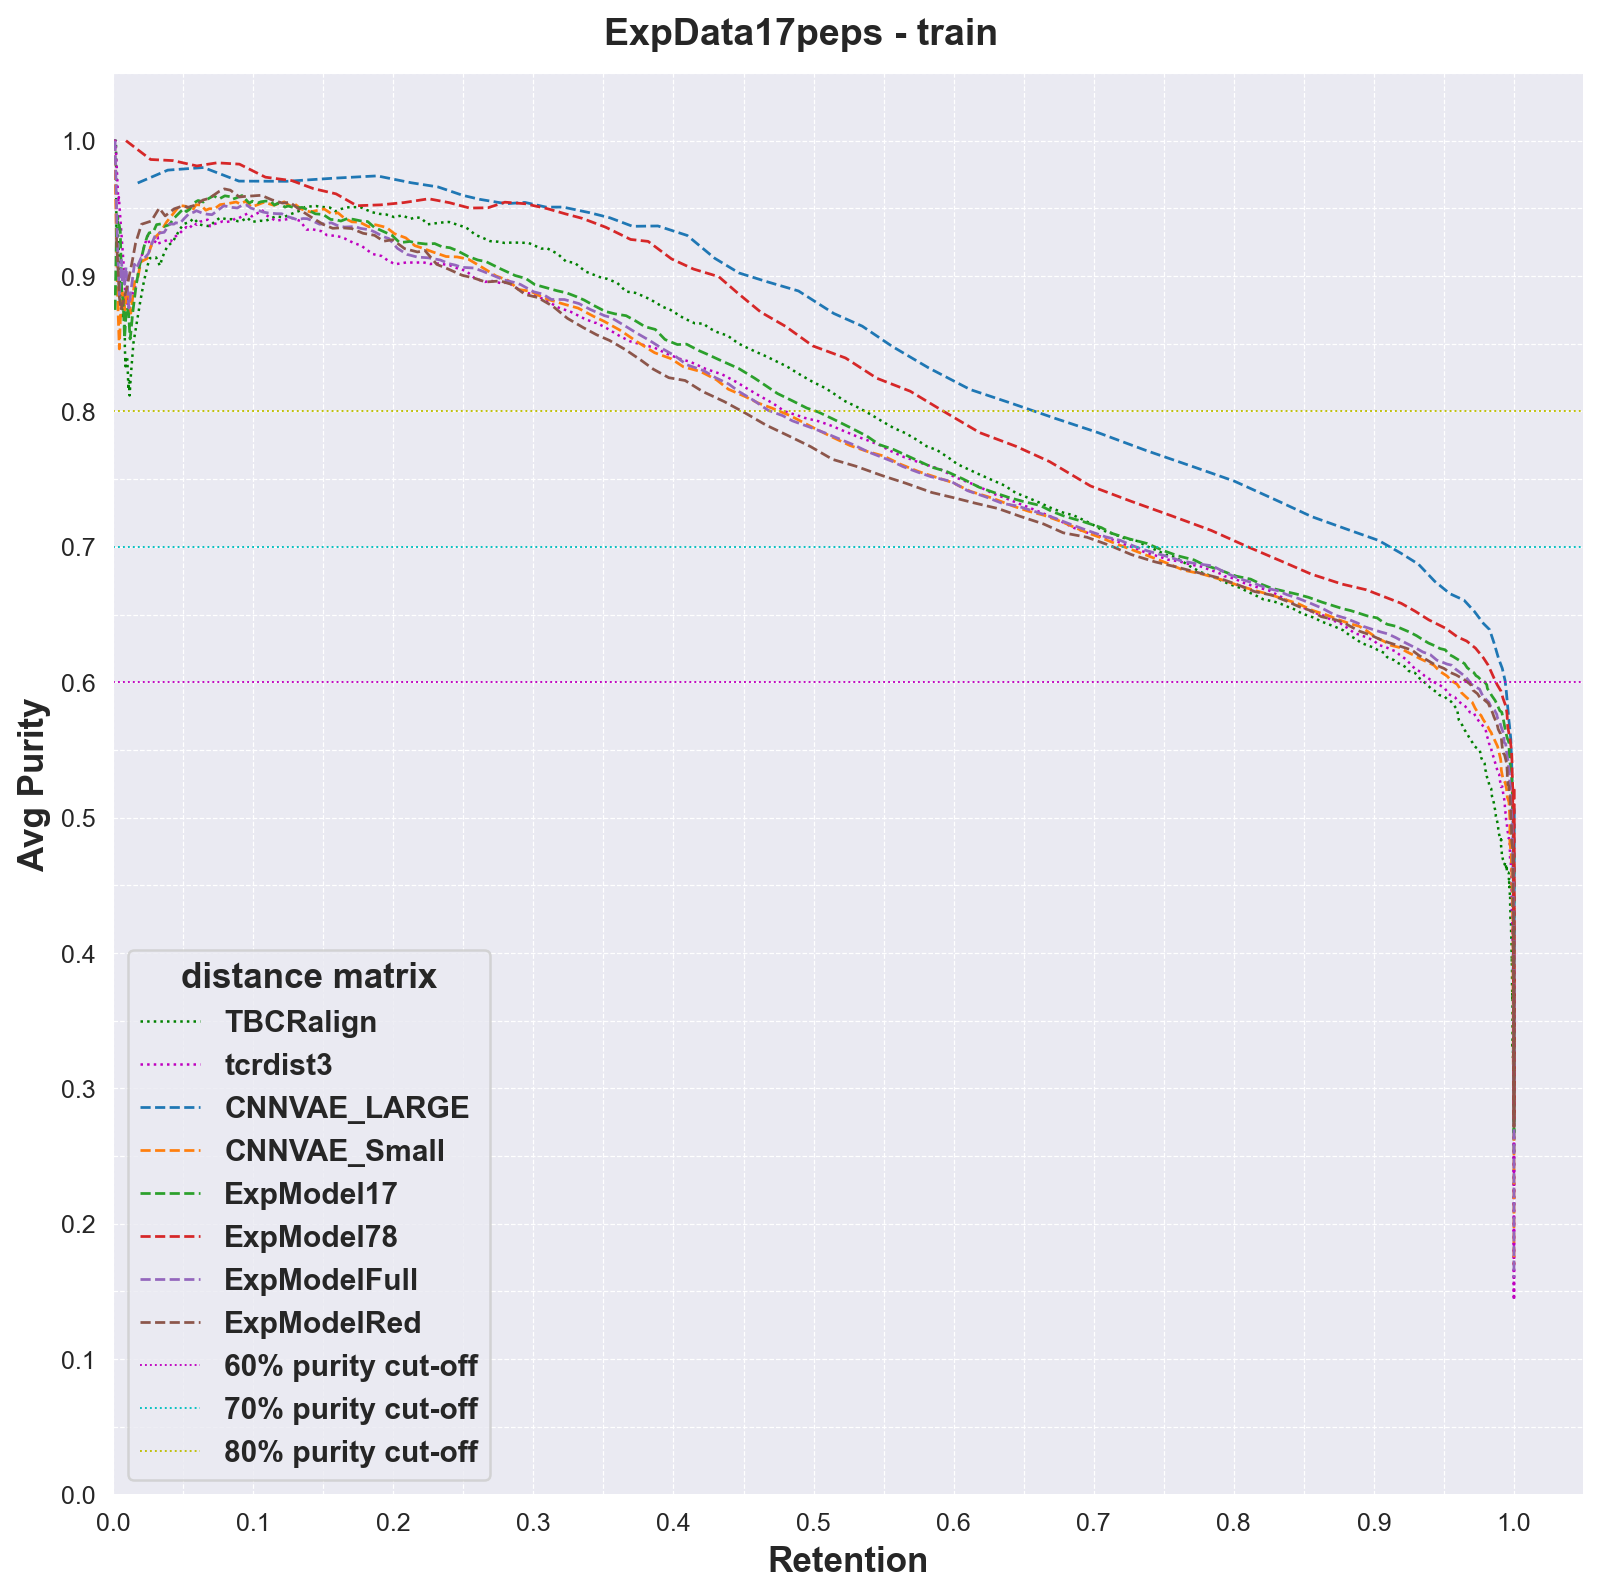

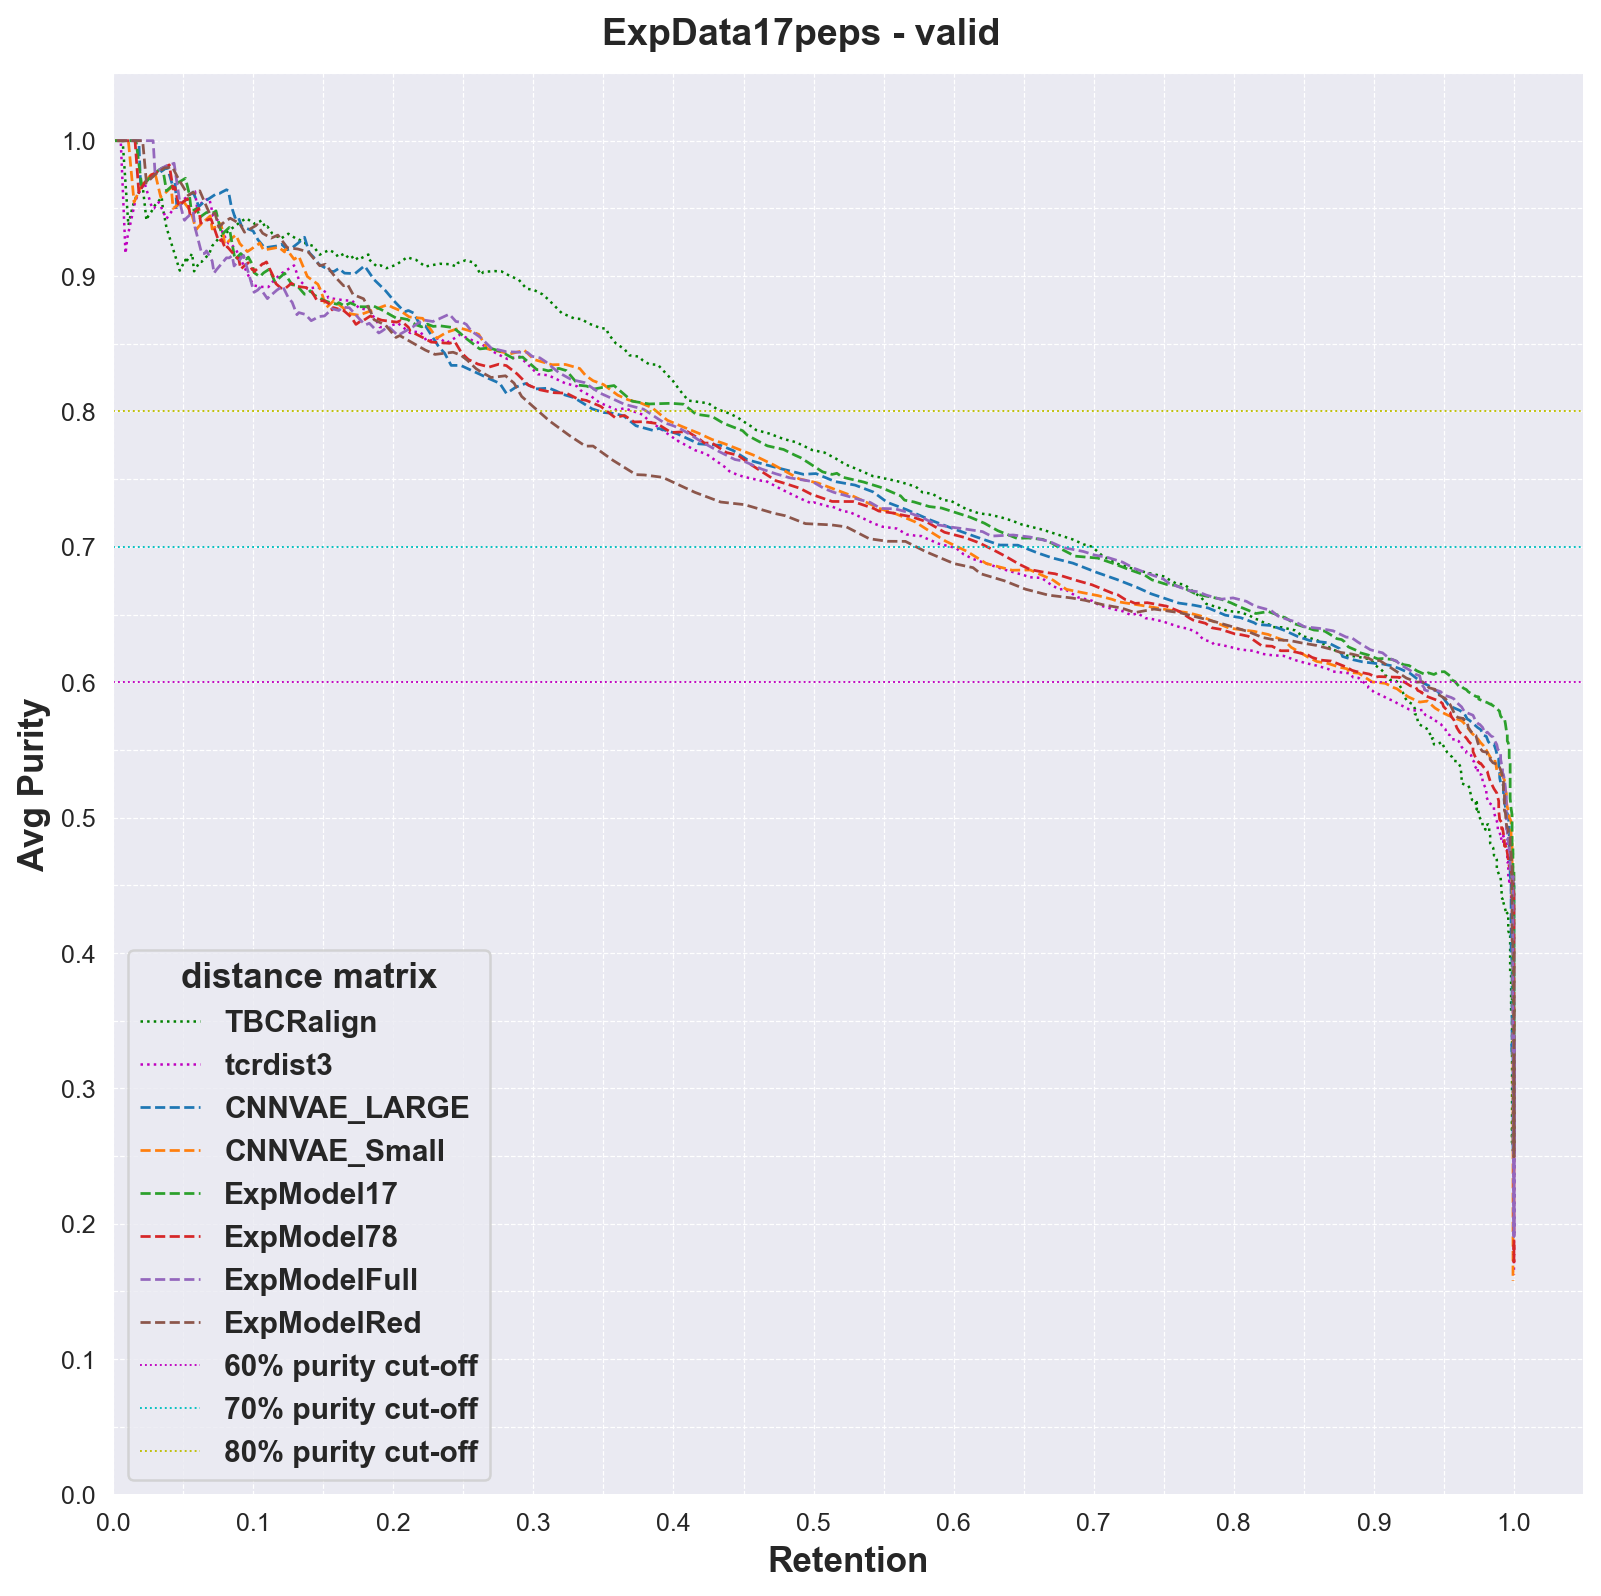

In [72]:
prune_results = {}
savedir = f'../output/240515_IntervalClustering/figs/'
mkdirs(savedir)
for k in ['OldDataTop15', 'OldDataTop20' ,'OldDataNoPrune', 'ExpDataTop78', 'ExpData17peps']:
    prune_results[k] = {}
    for set in ['train', 'valid']:
        prune_results[k][set] = get_best_given_dir(f'../output/240515_IntervalClustering/{k}/', set, k)
        prune_results[k][set].input_type = prune_results[k][set].input_type.apply(lambda x: x.split('_'+k)[0])
        plot_pipeline_all(prune_results[k][set], f'{k} - {set}', f'{savedir}{k}_{set}', 'tab10')

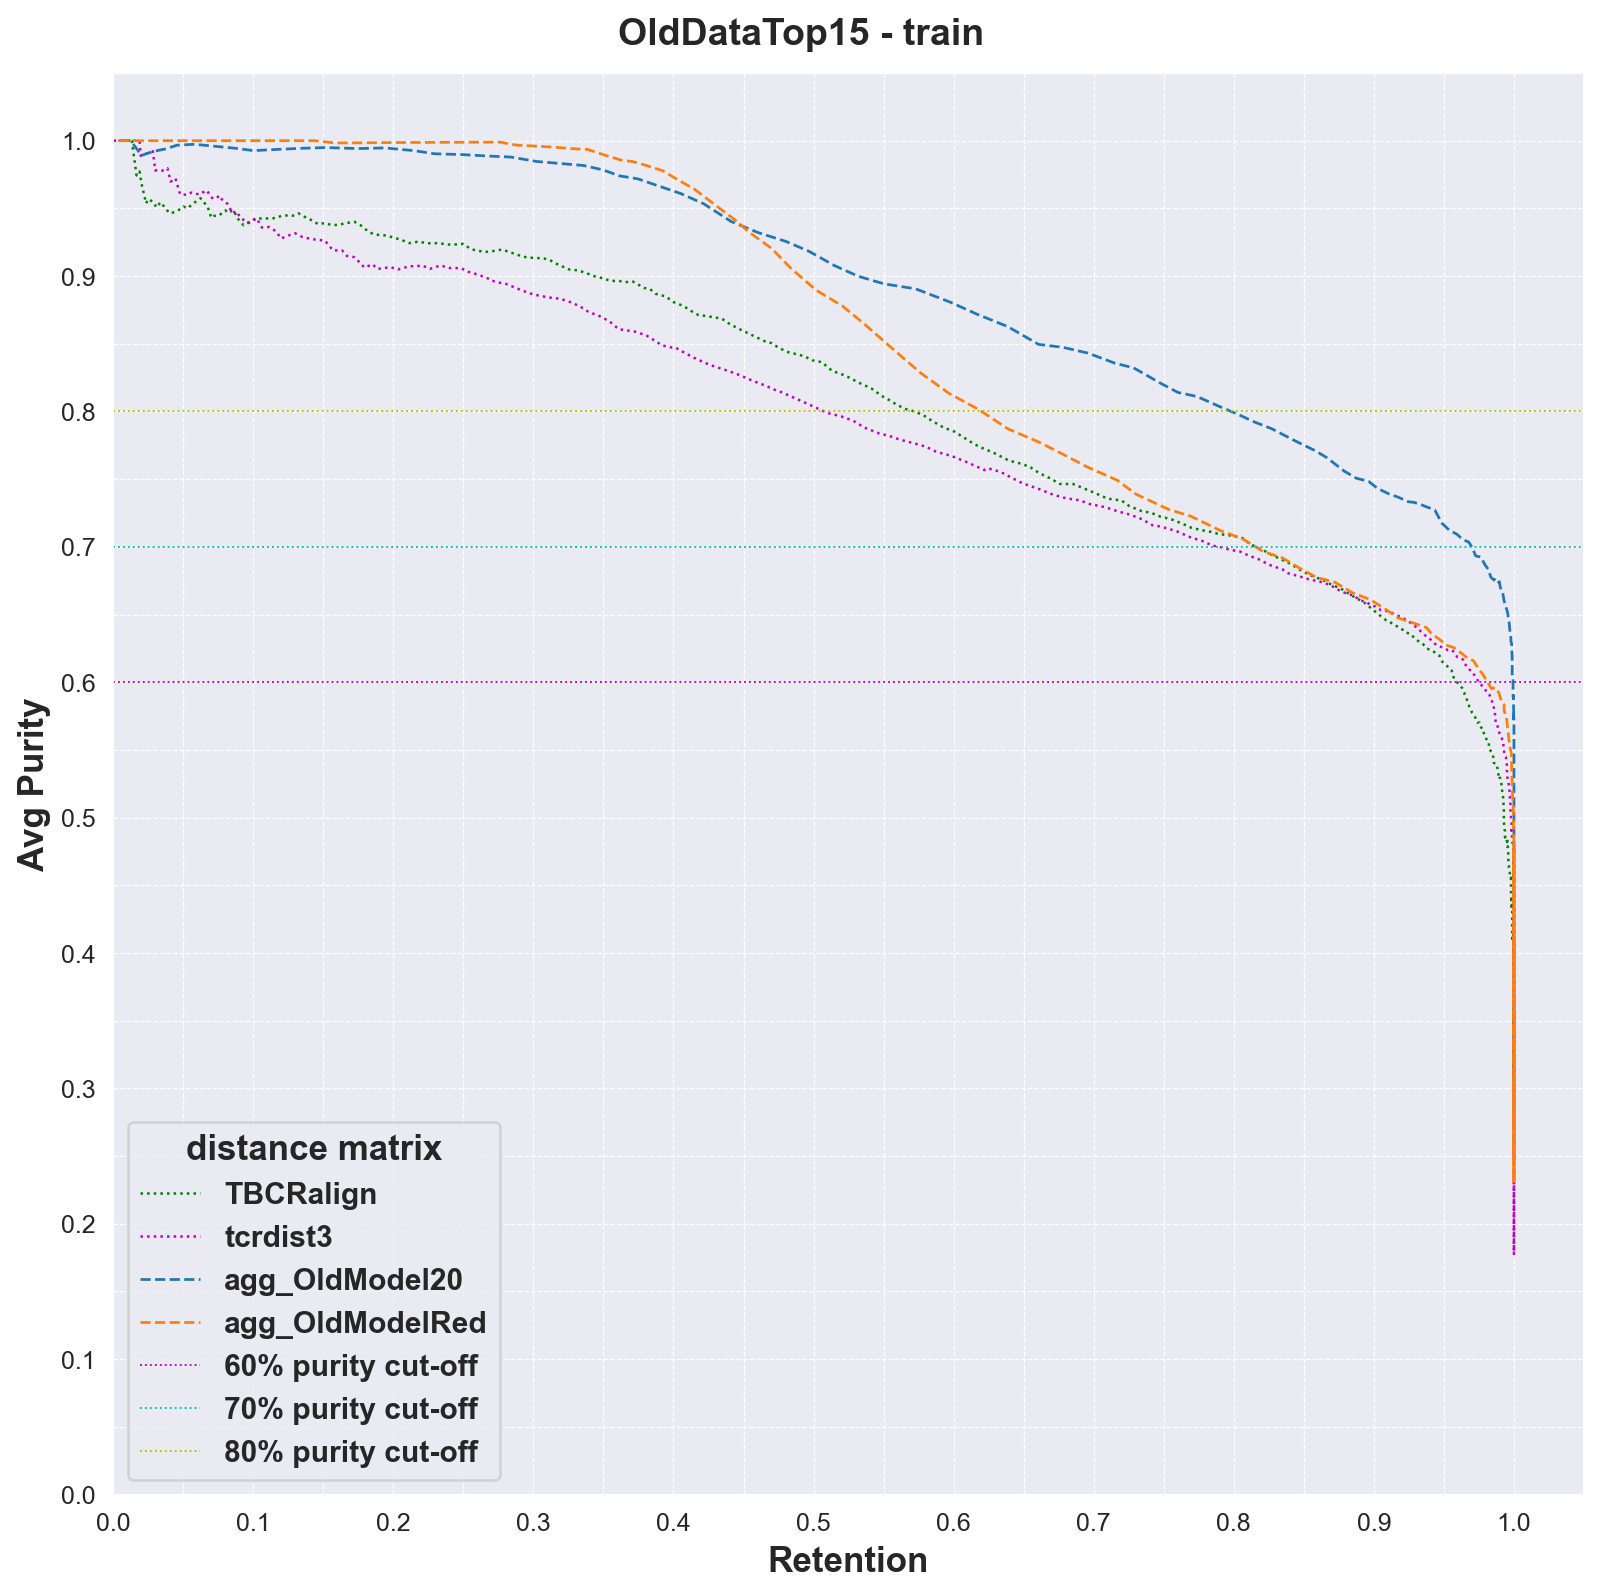

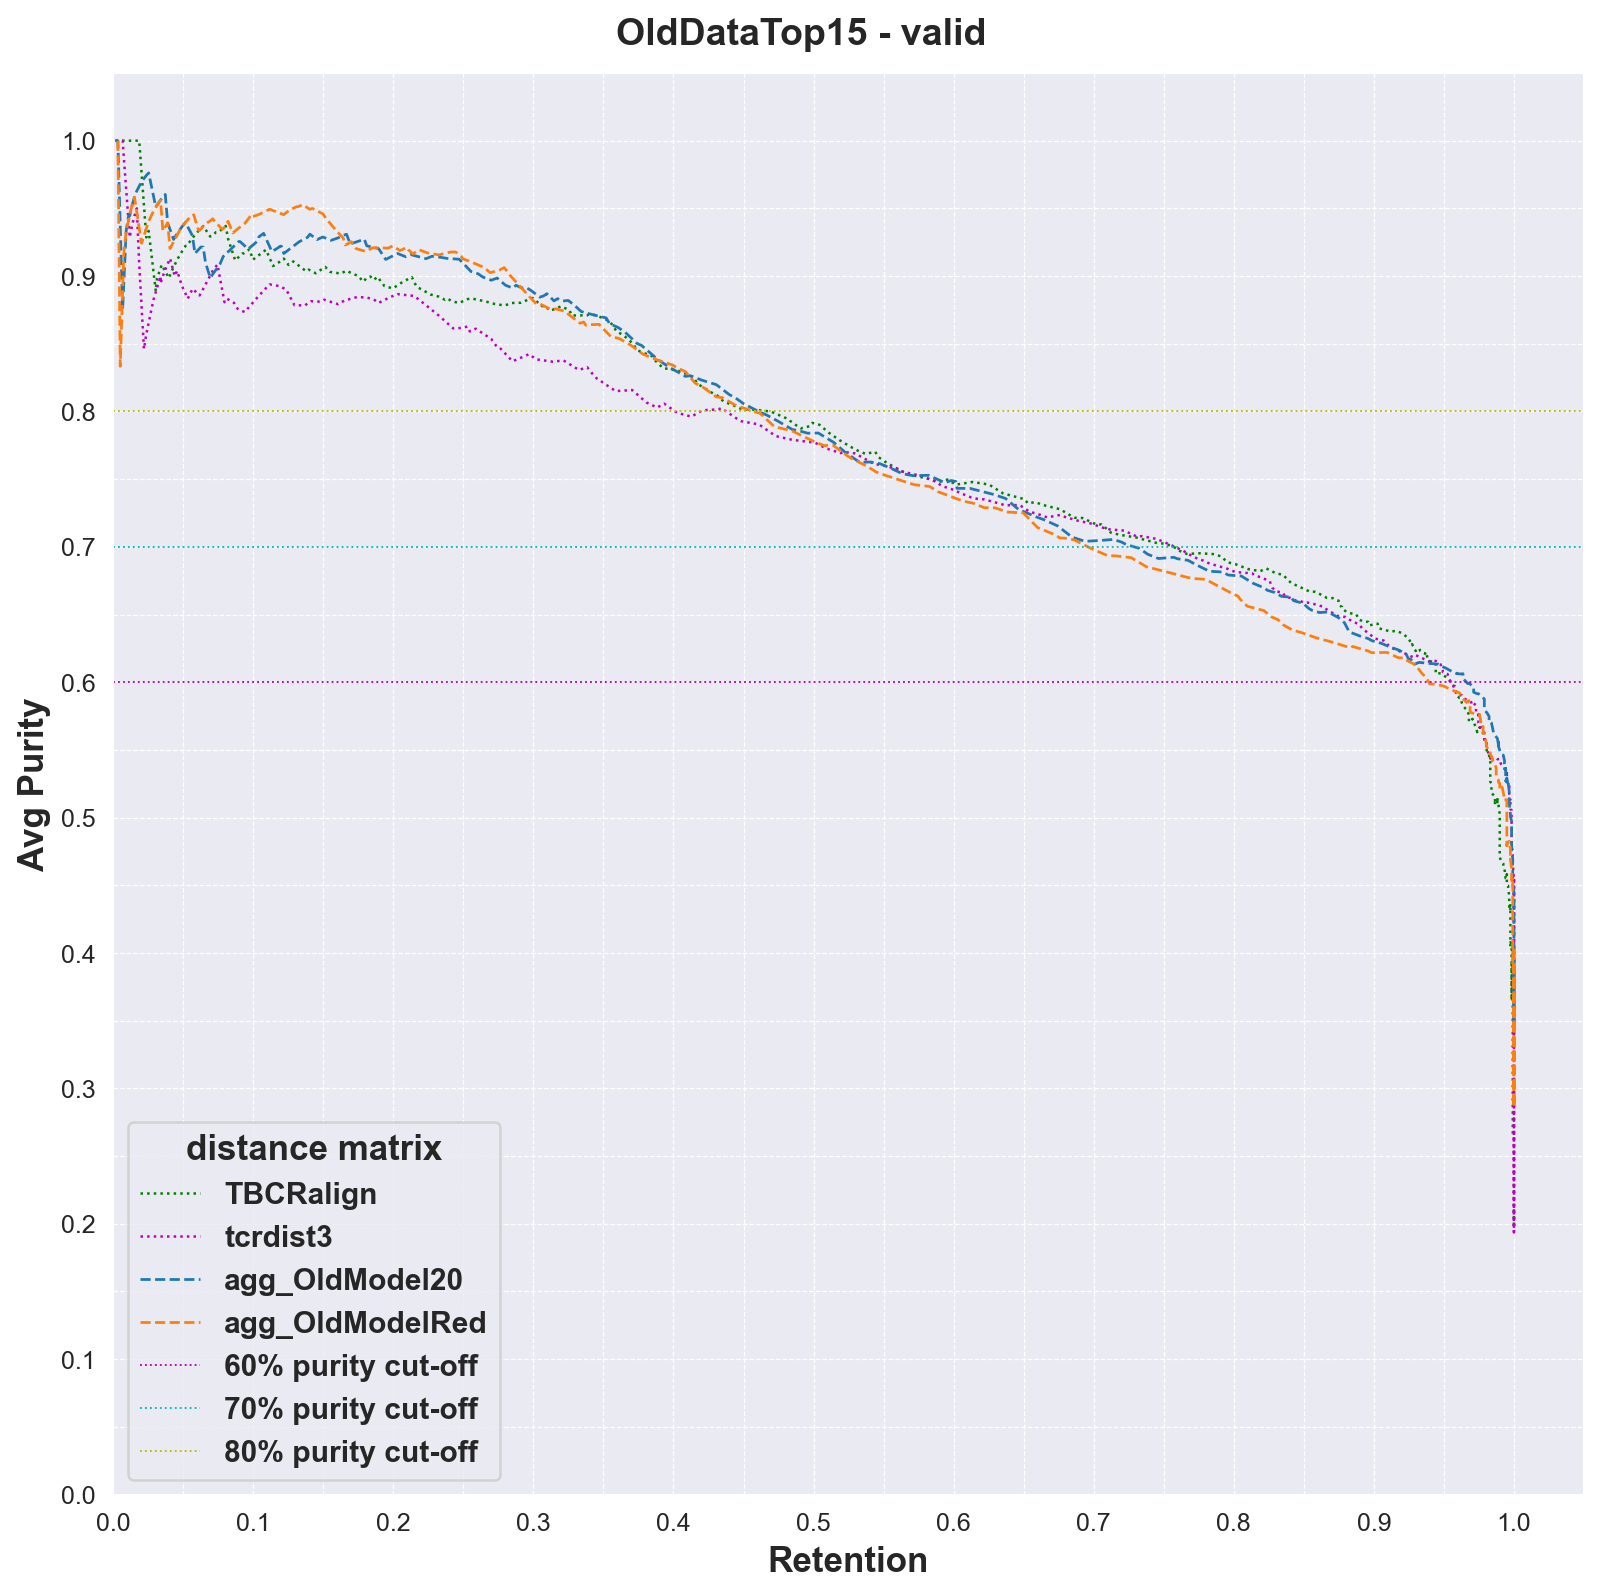

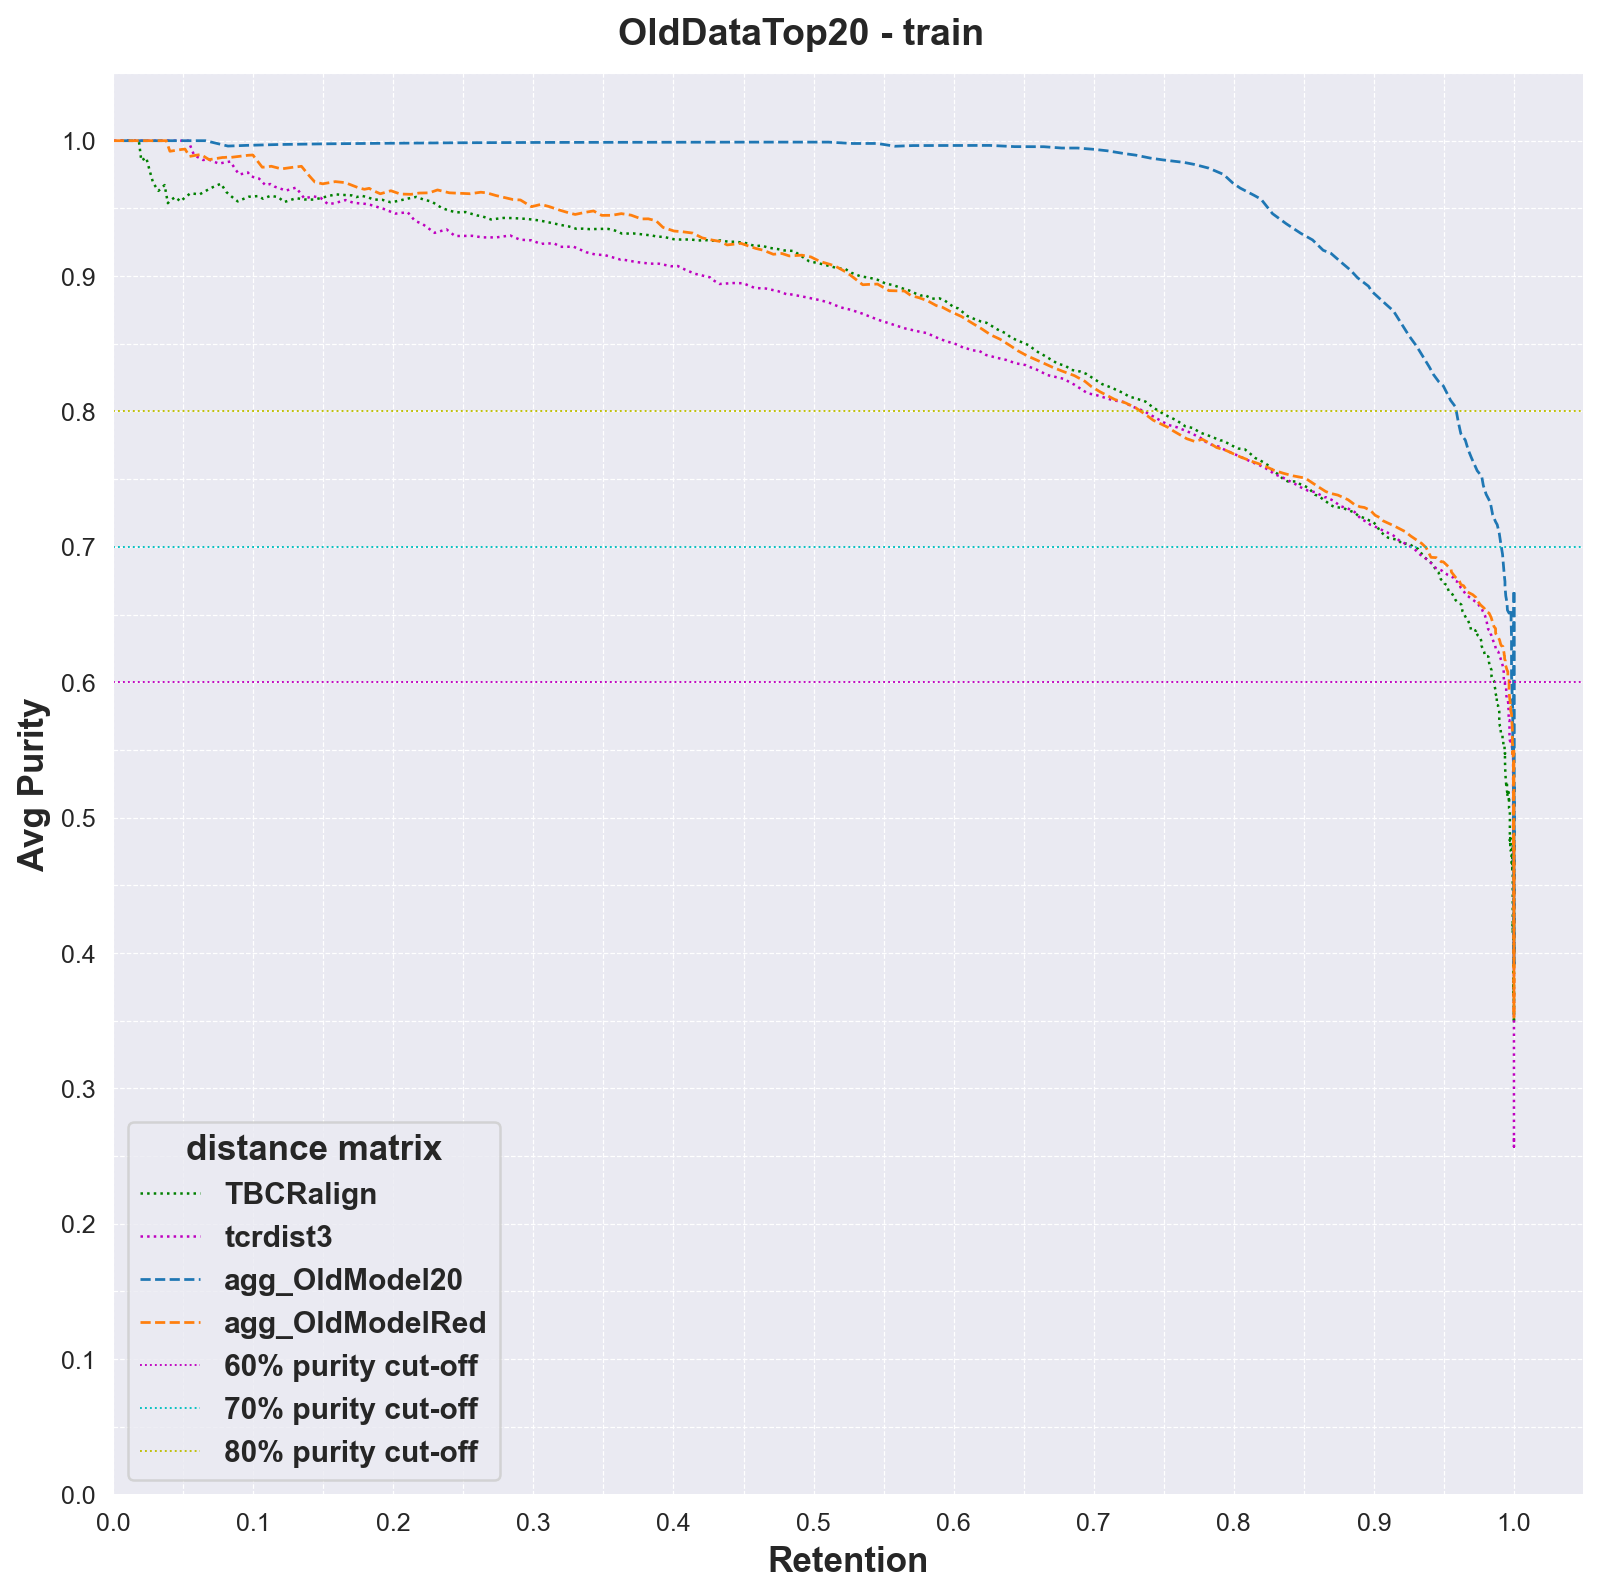

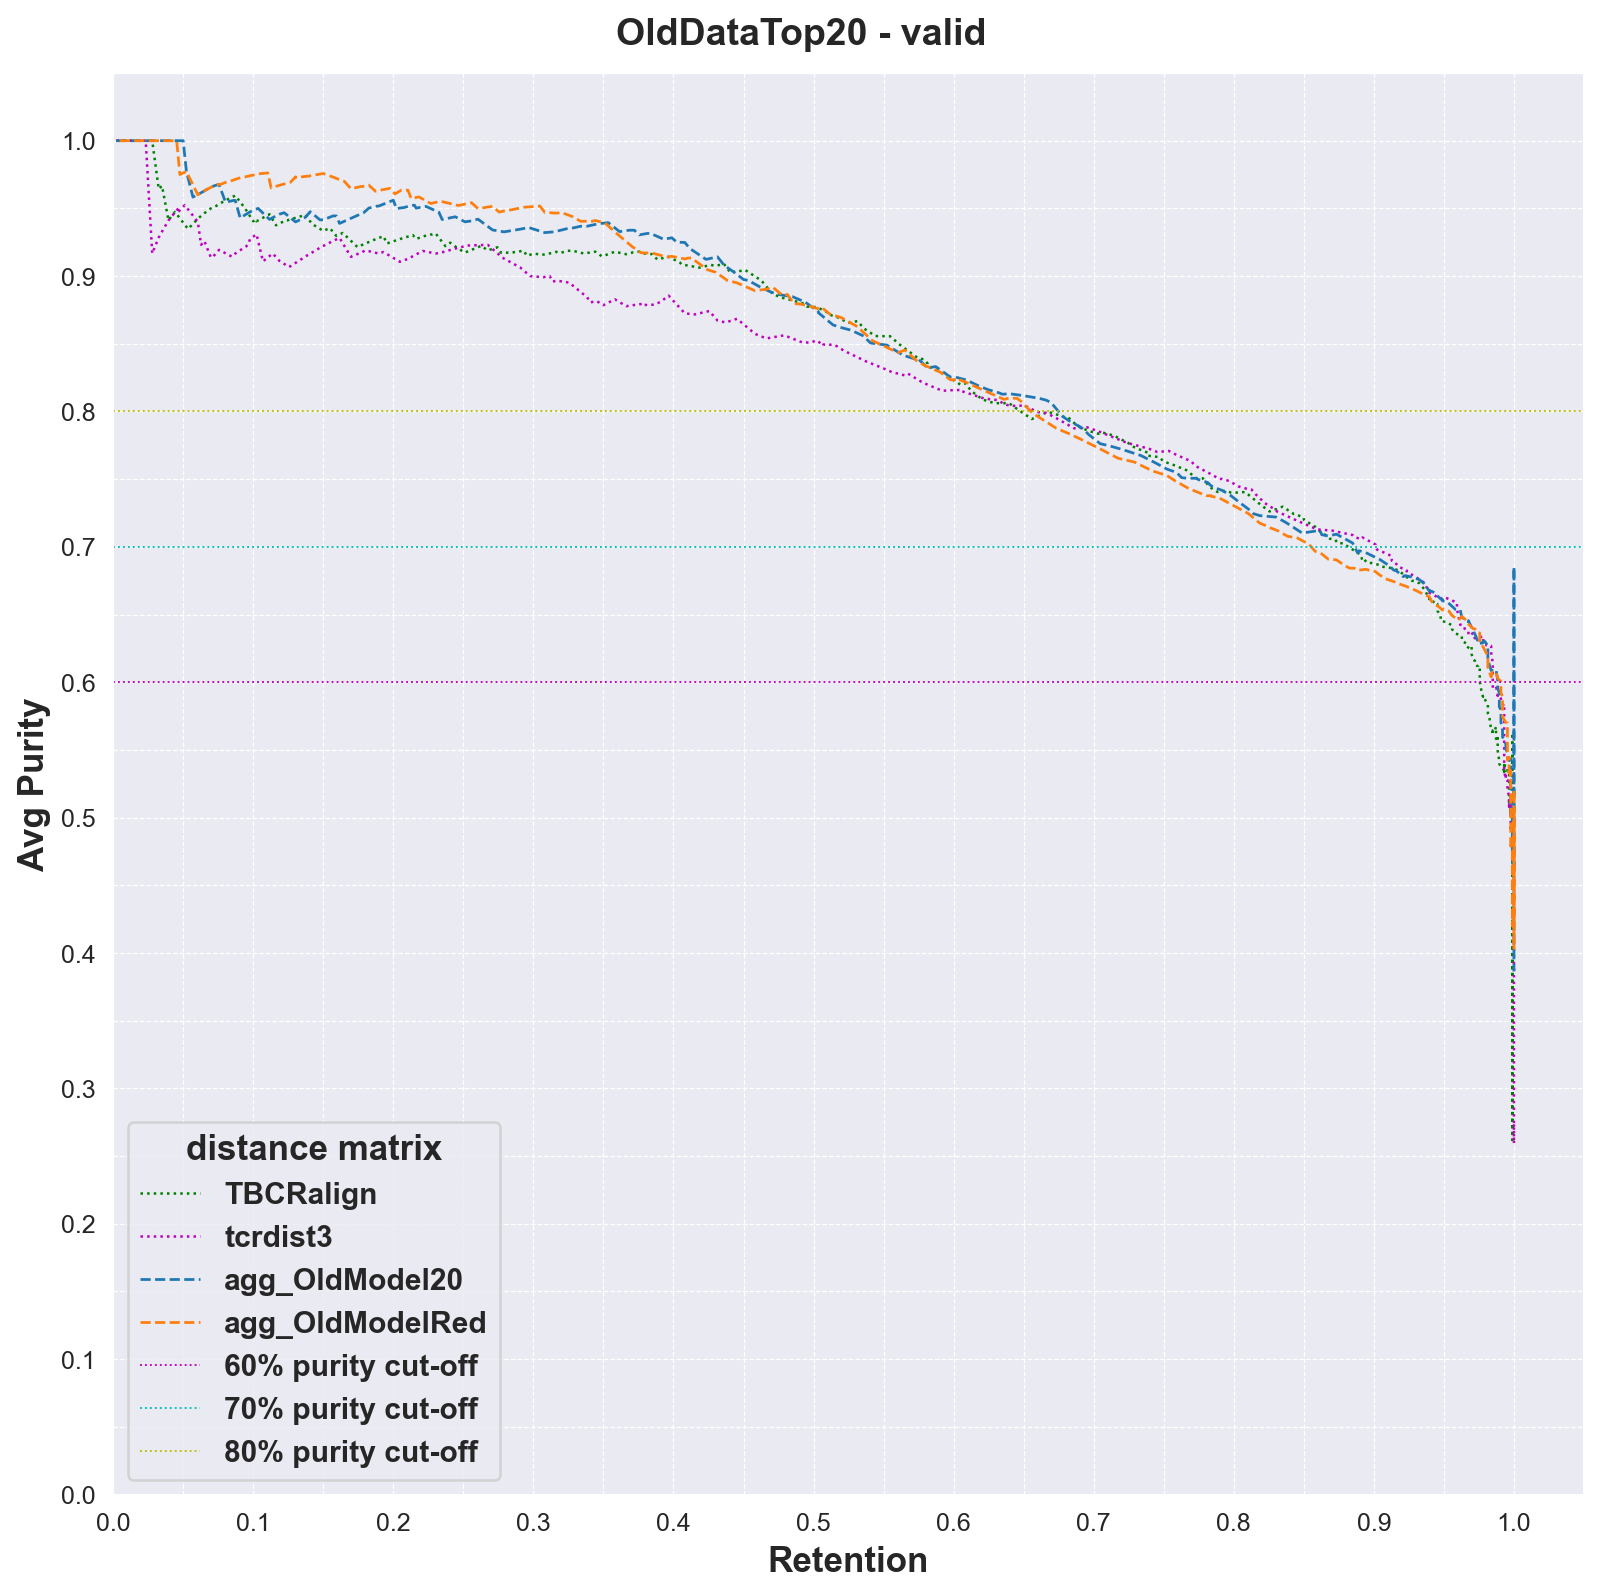

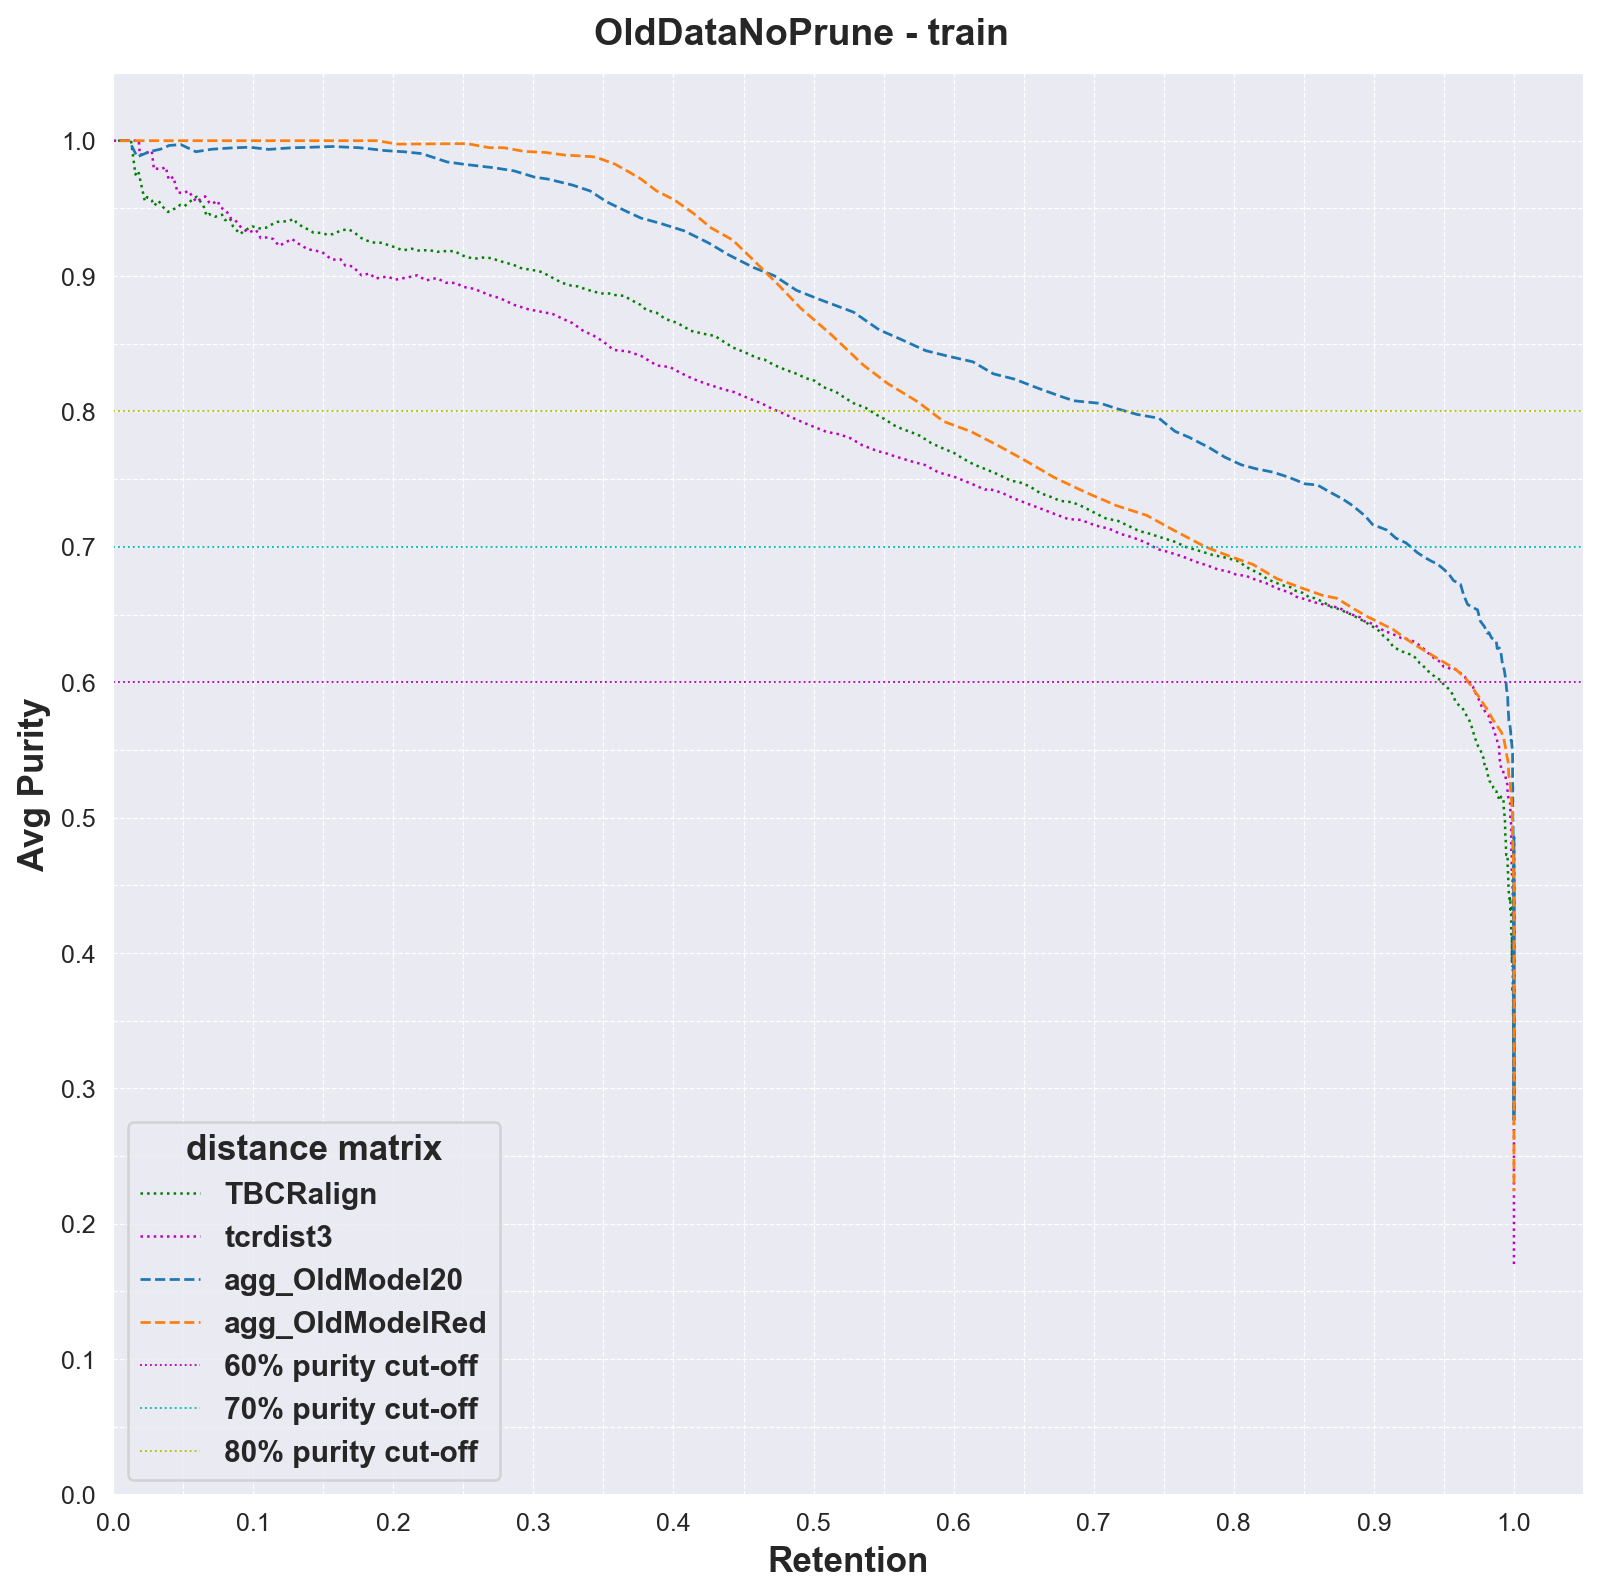

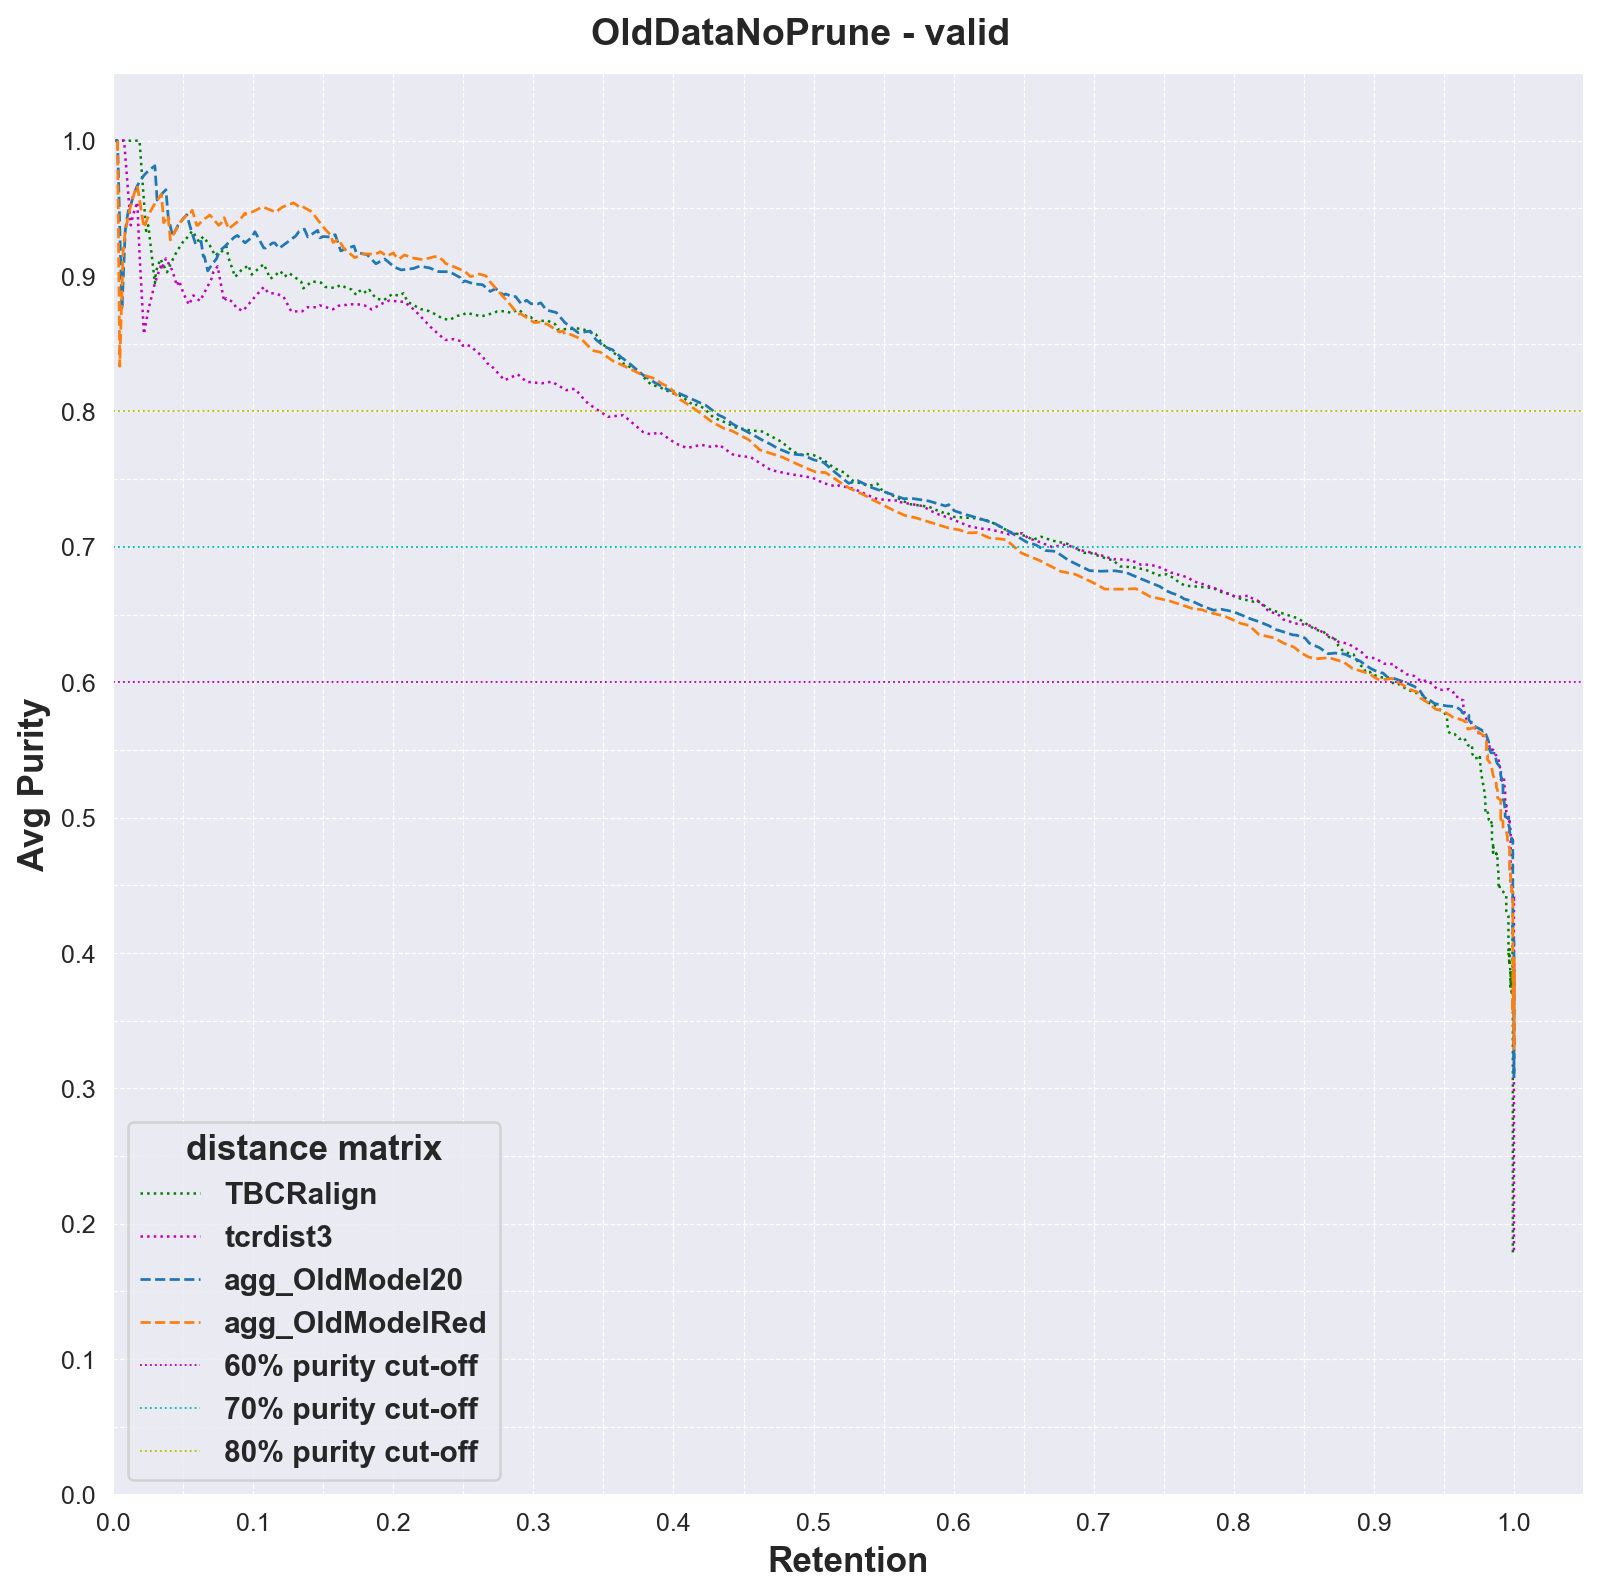

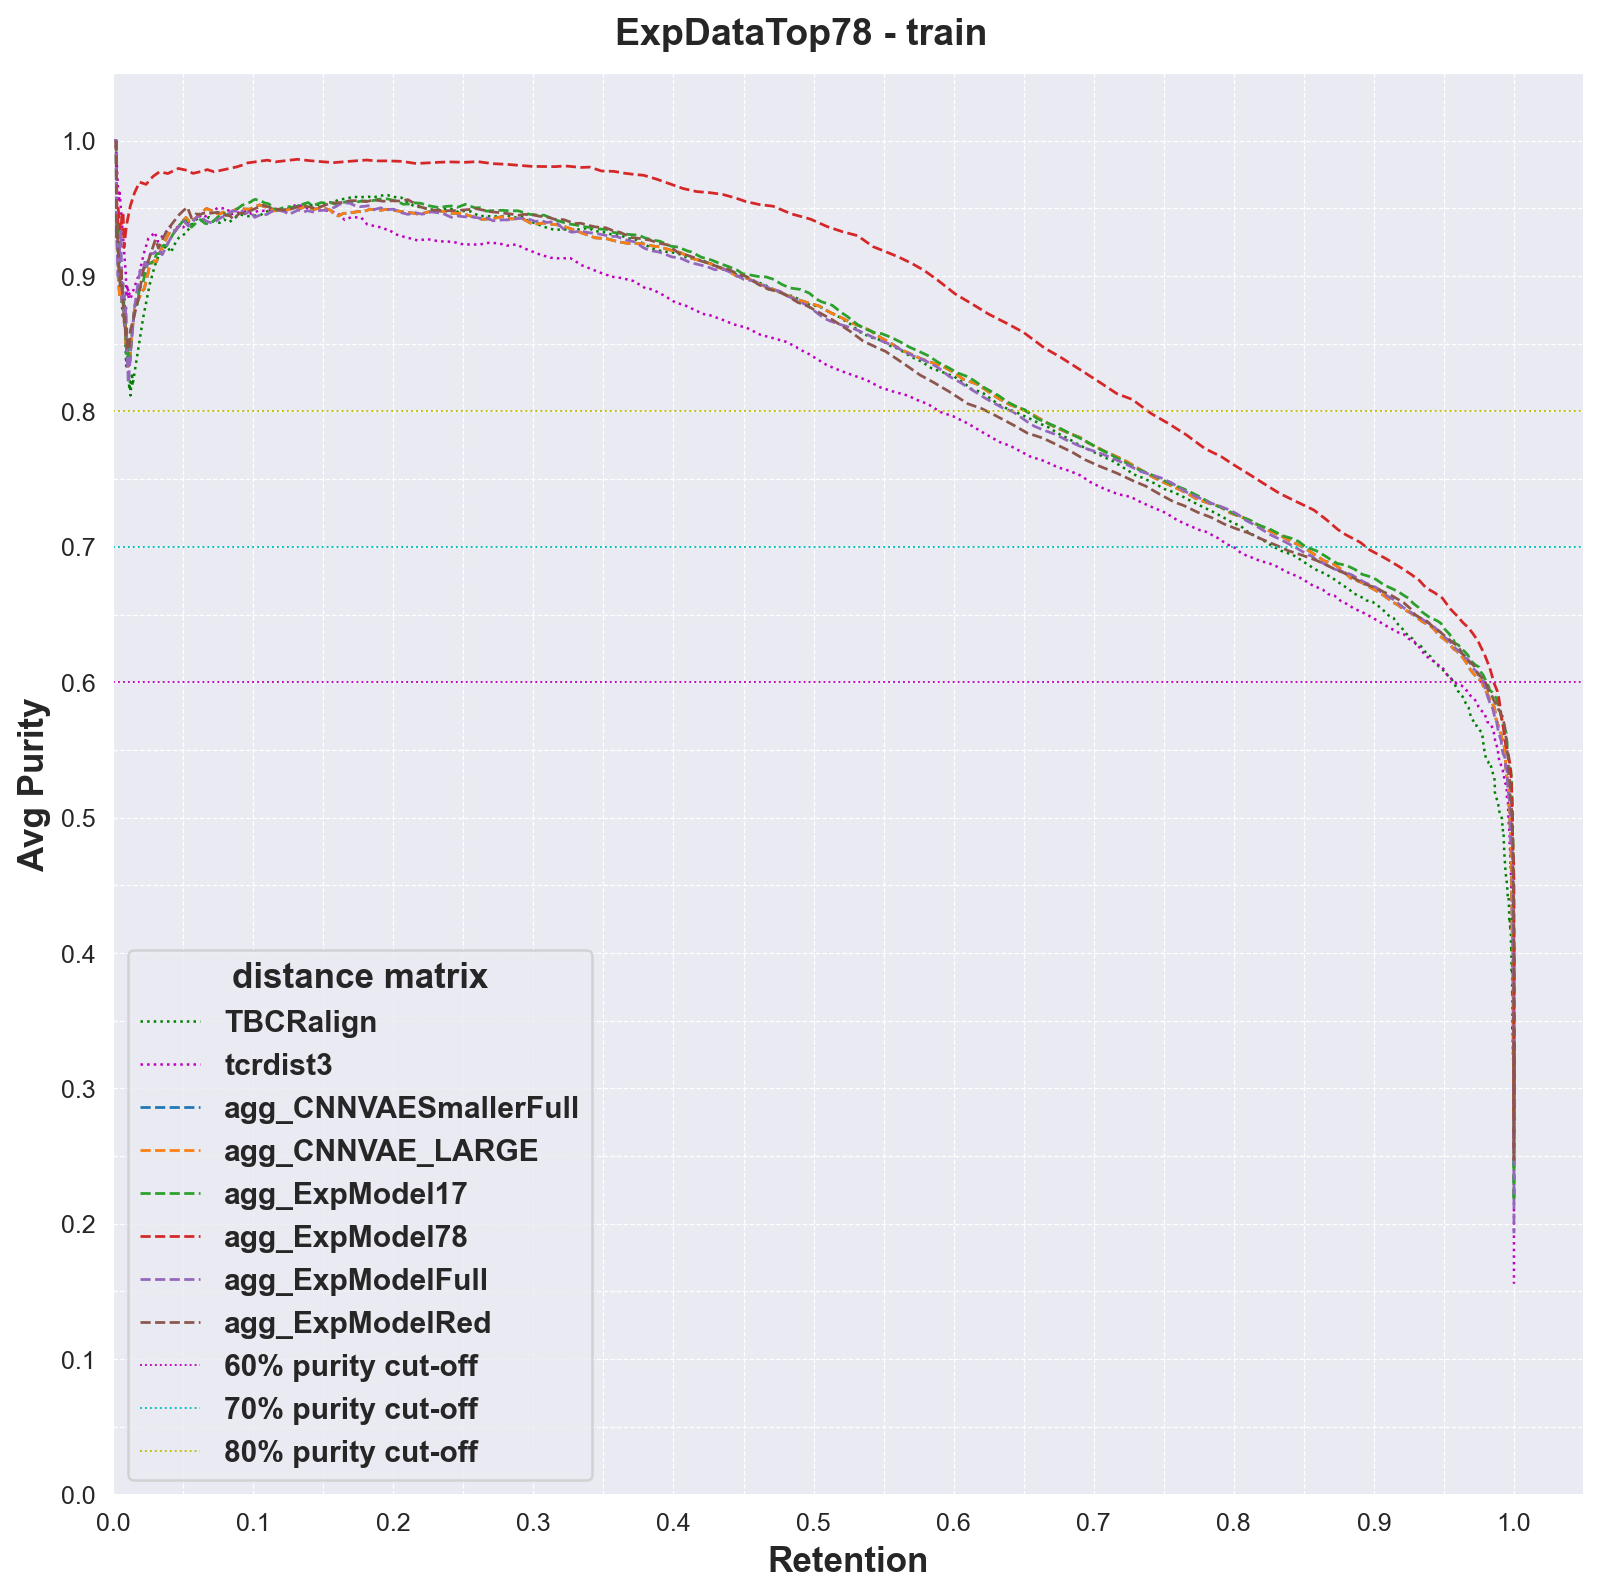

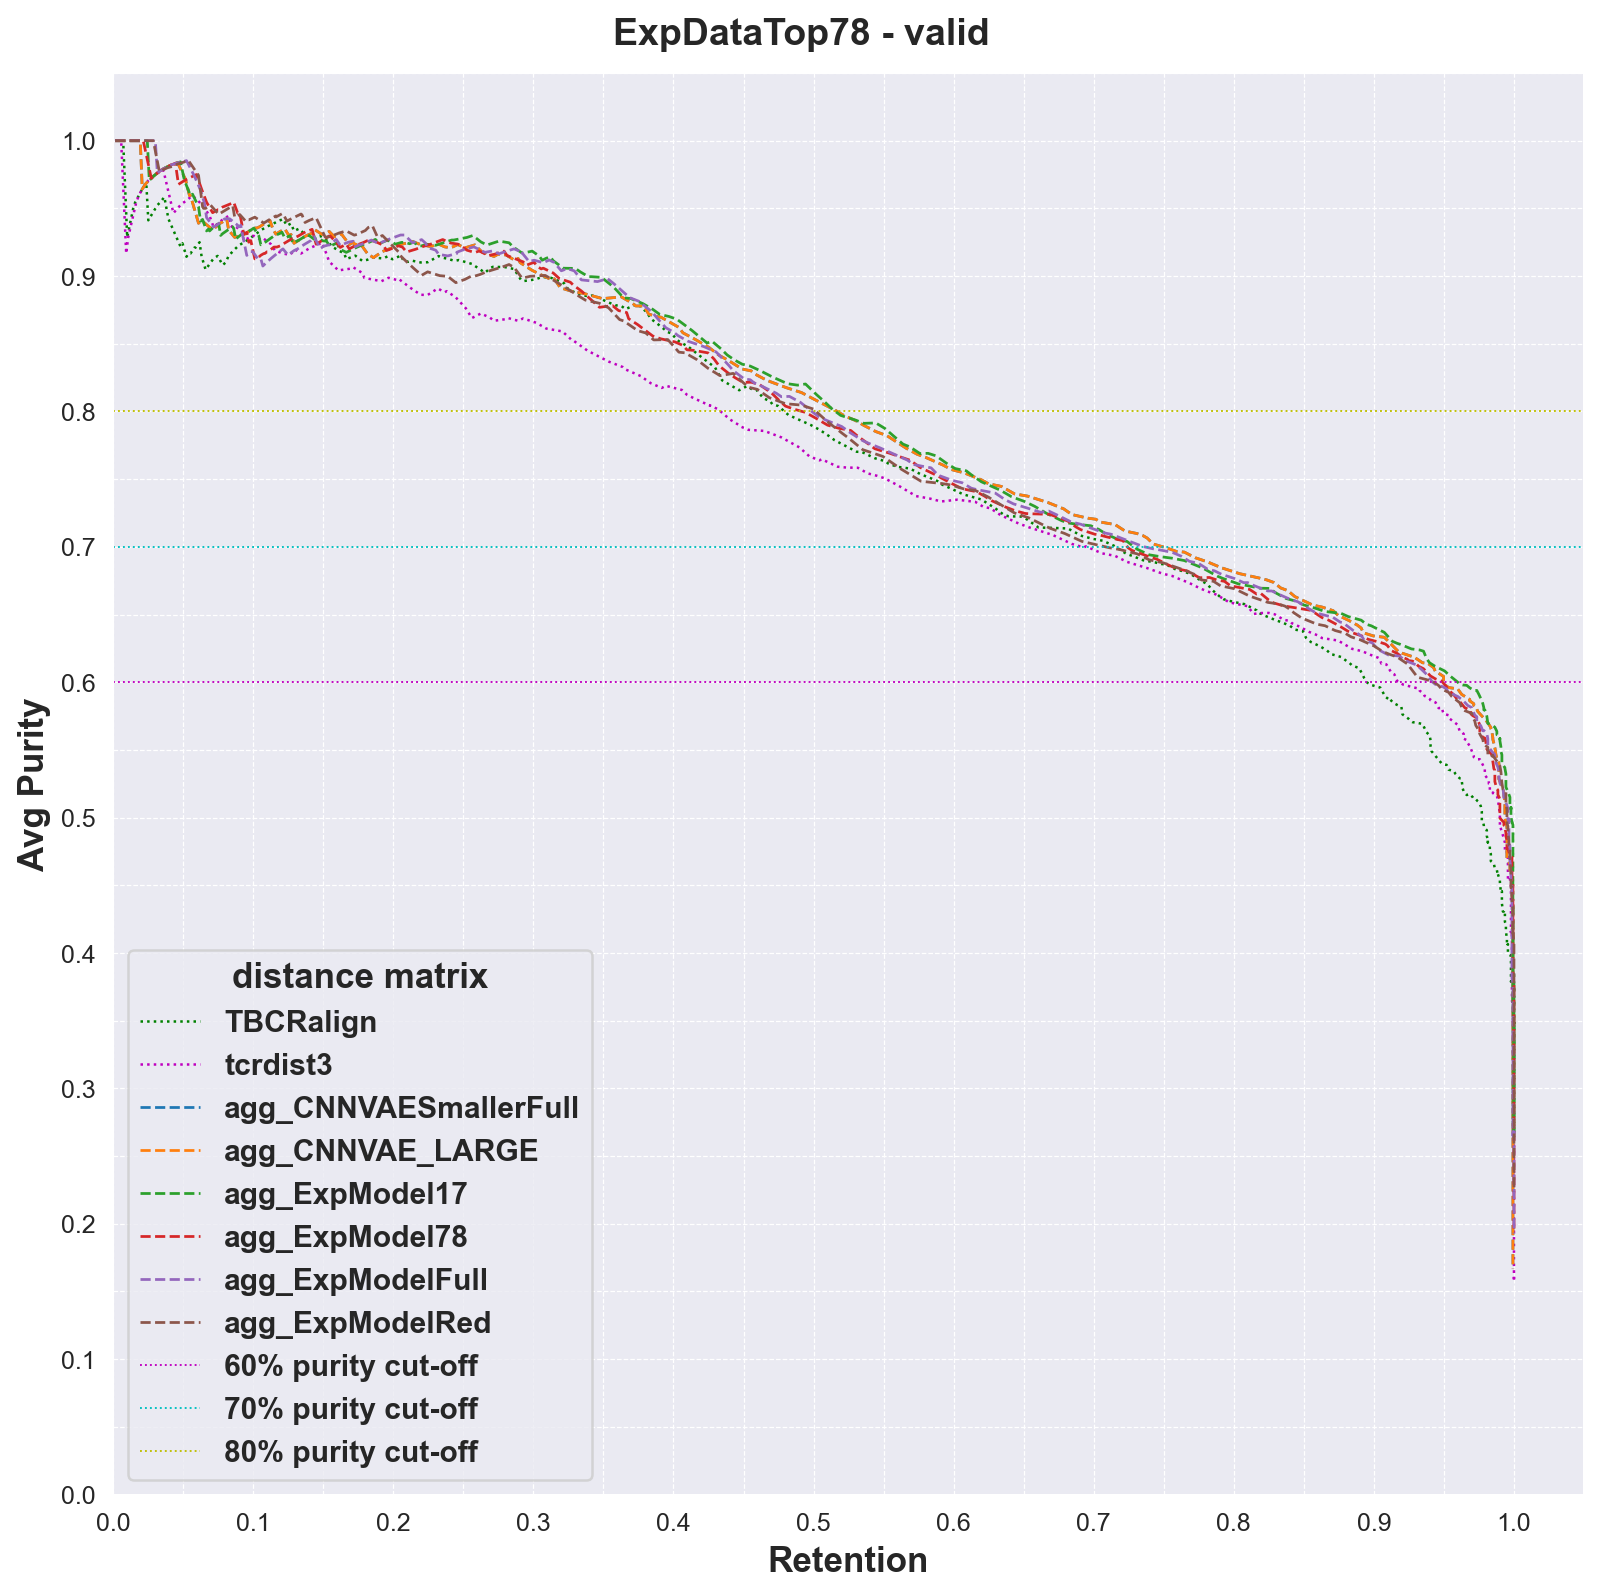

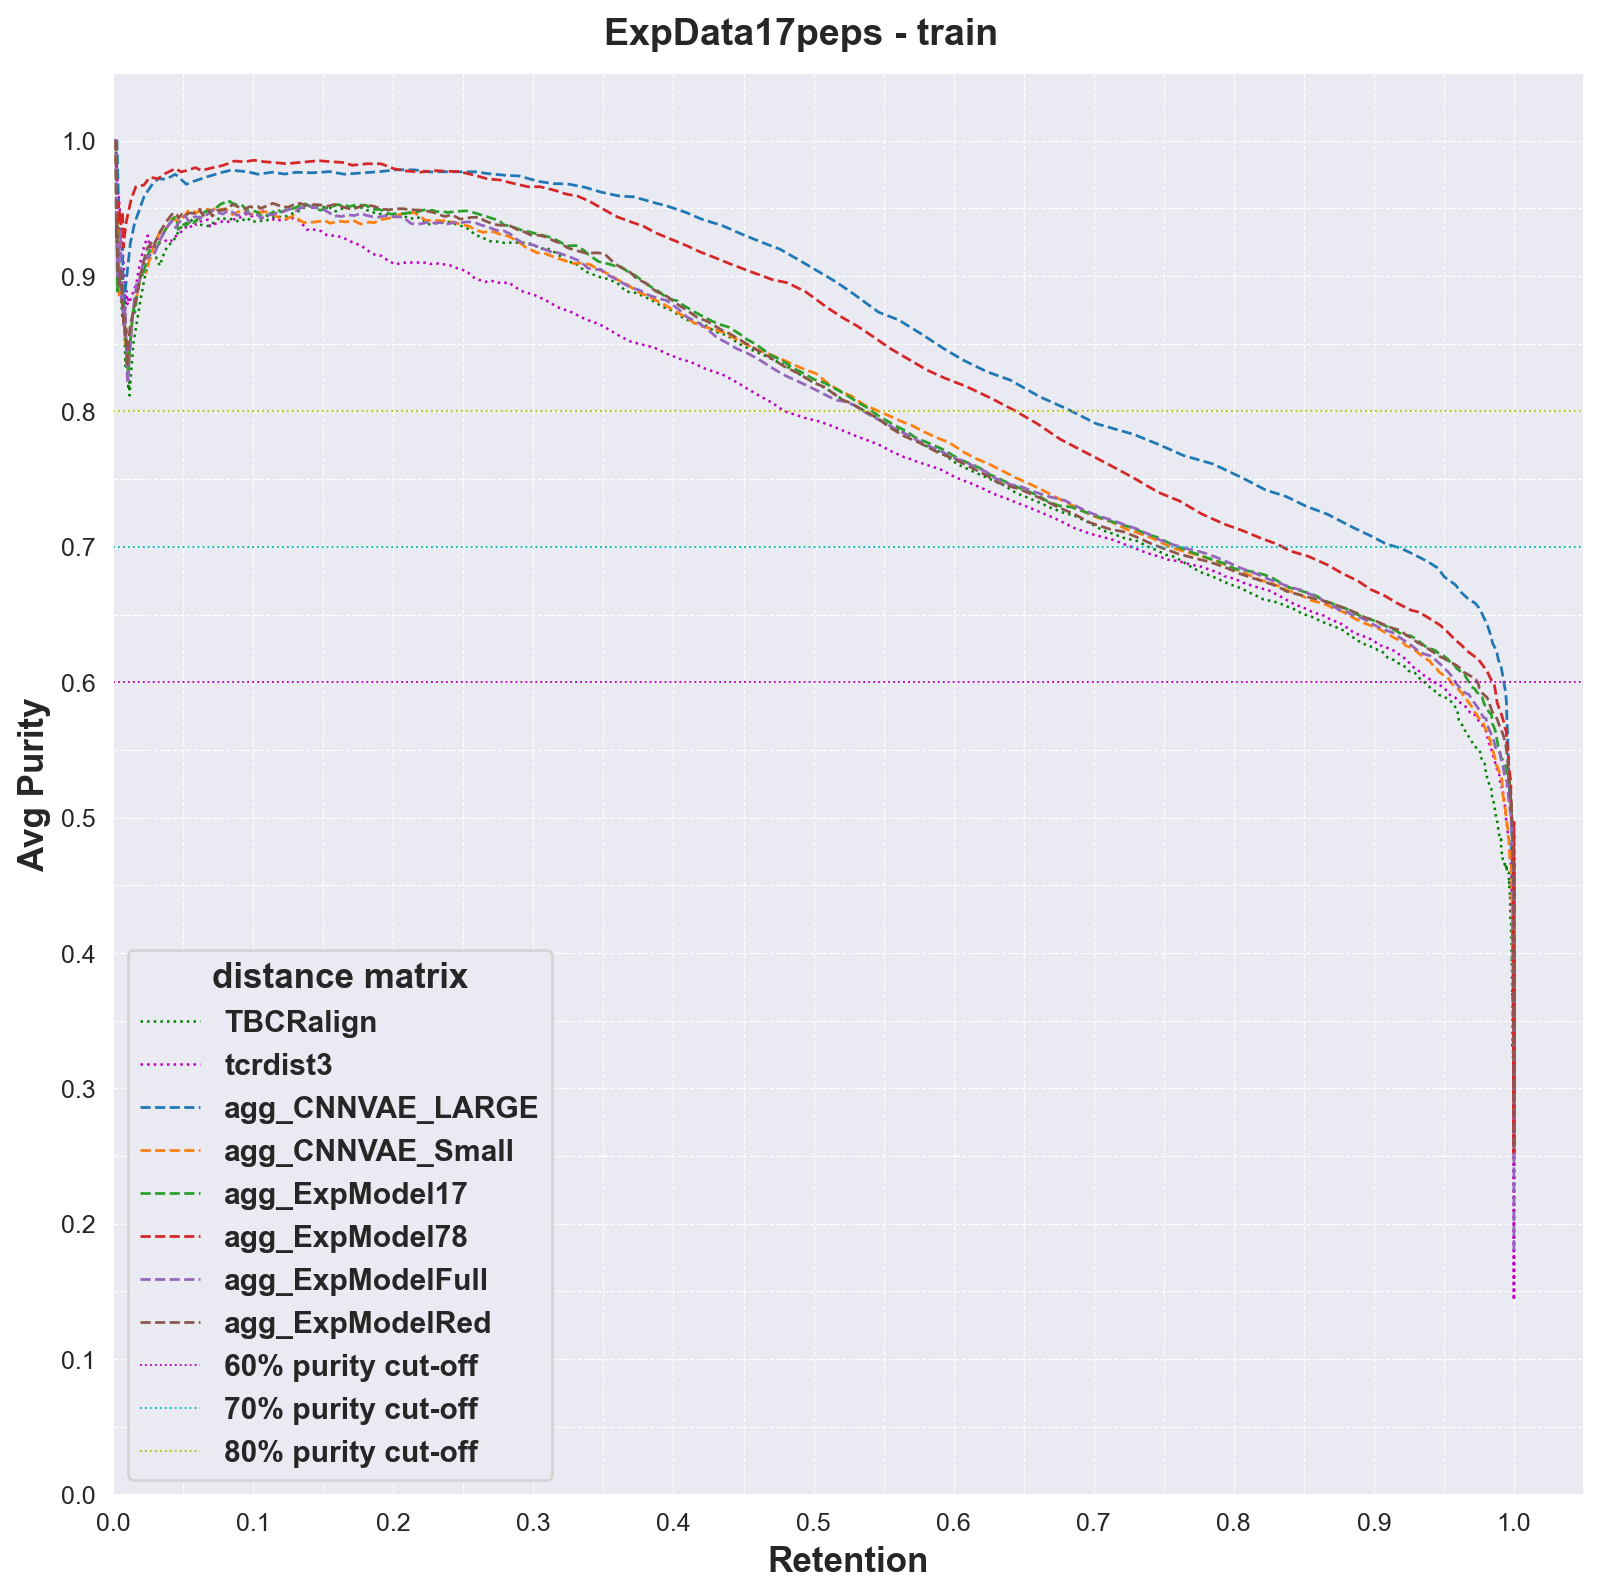

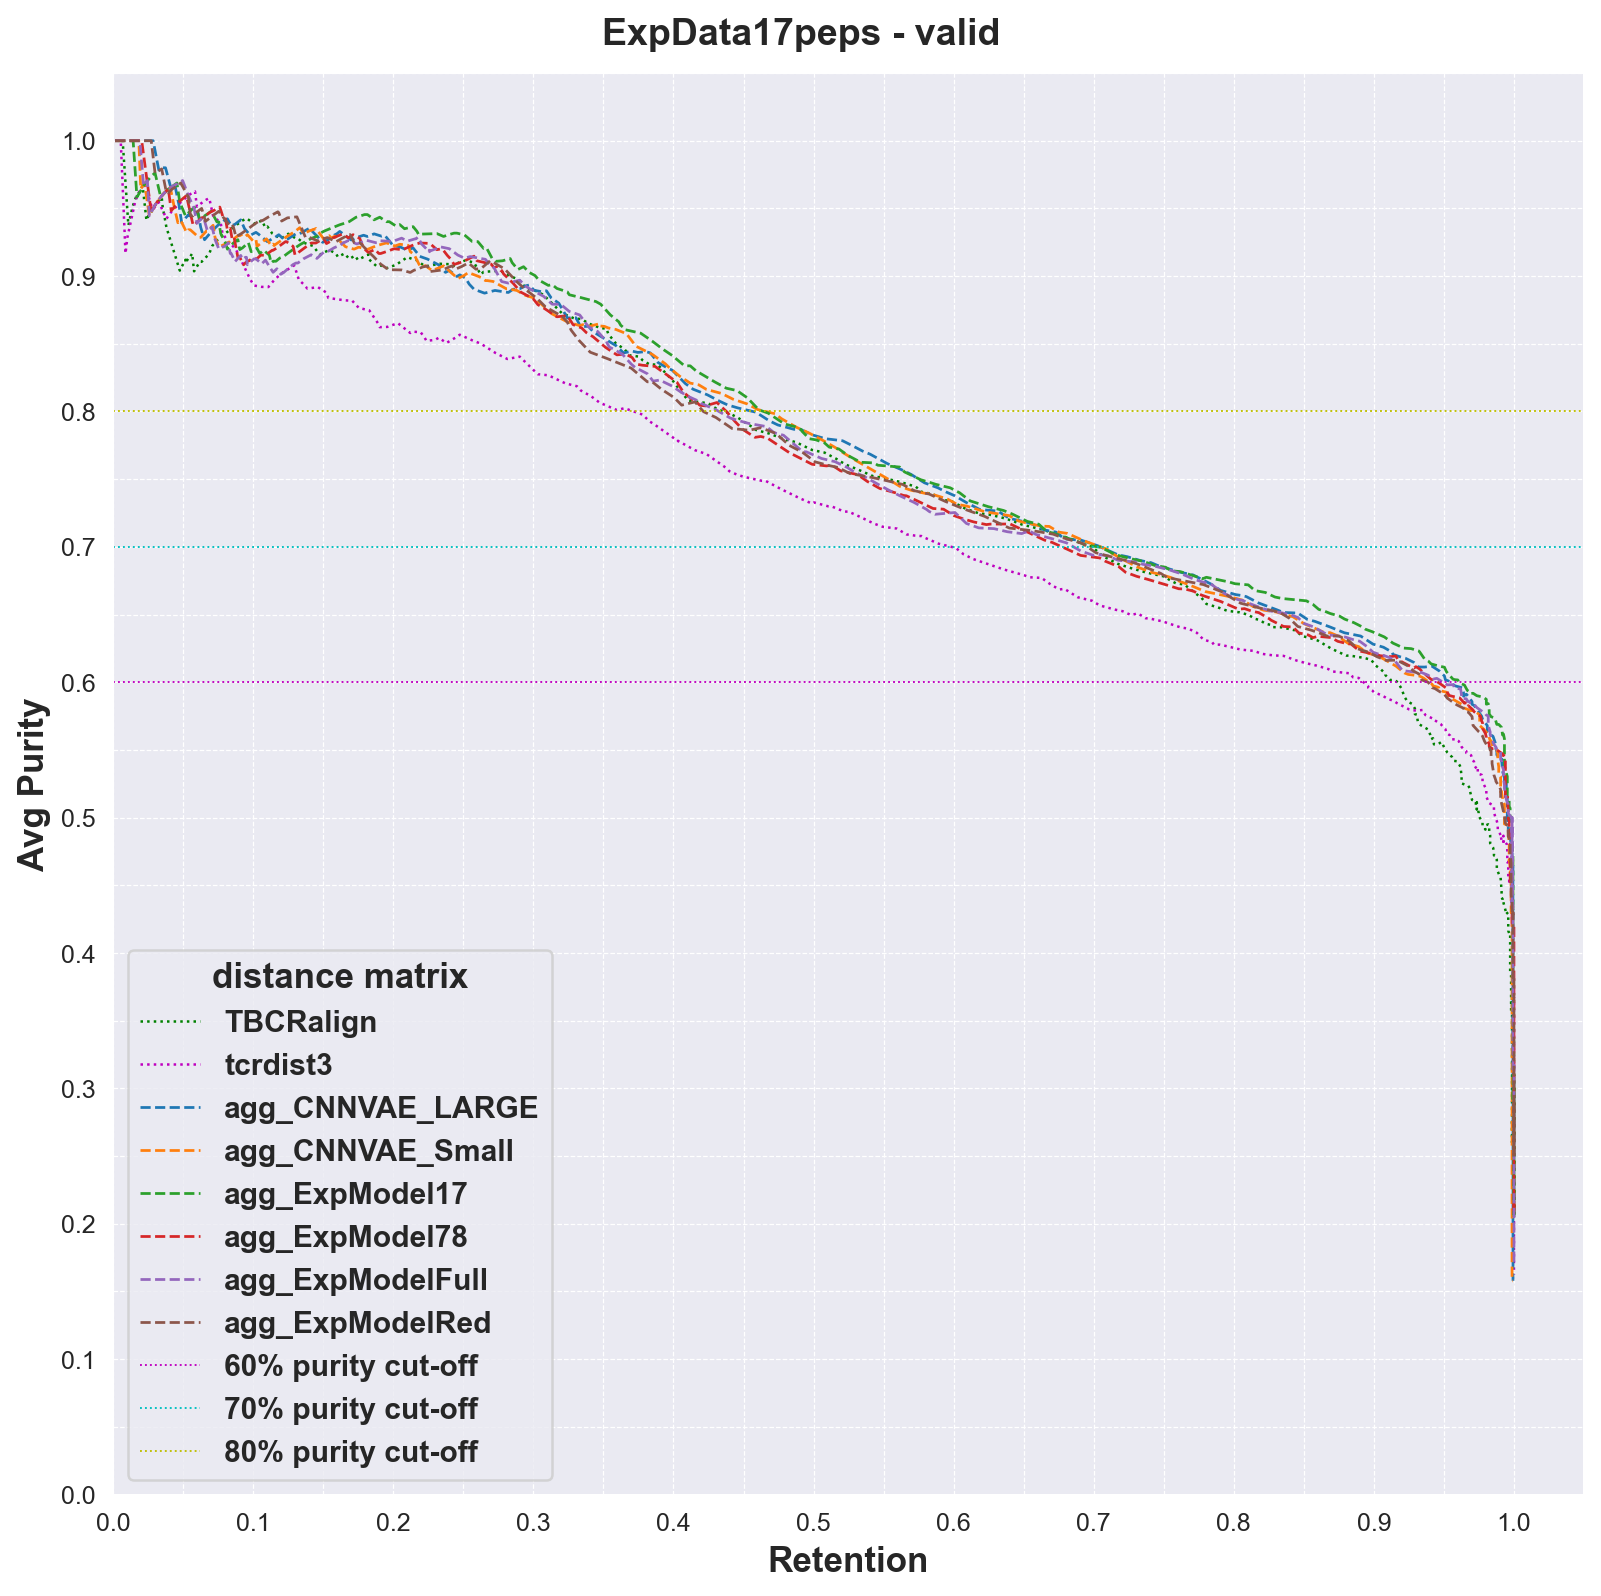

In [73]:
prune_agg_results = {}
savedir = f'../output/240515_IntervalClustering/figs/'
mkdirs(savedir)
for k in ['OldDataTop15', 'OldDataTop20' ,'OldDataNoPrune', 'ExpDataTop78', 'ExpData17peps']:
    prune_agg_results[k] = {}
    for set in ['train', 'valid']:
        prune_agg_results[k][set] = get_agg_given_dir(f'../output/240515_IntervalClustering/{k}/', set, k)
        prune_agg_results[k][set].input_type = prune_agg_results[k][set].input_type.apply(lambda x: x.split('_'+k)[0])
        plot_pipeline_all(prune_agg_results[k][set], f'{k} - {set}', f'{savedir}AggModels_{k}_{set}', 'tab10')

## Old Data

# NXMinimum spanning trees

In [17]:
import networkx as nx
from src.cluster_utils import *

In [13]:
files_dict = pkl_load('../output/240411_ClusteringTests/files_dict.pkl')
comp_dict = pkl_load('../output/240411_ClusteringTests/comp_dict.pkl')

In [37]:
# Select the best model from FullExp 0200 KL 1e-1
folder = files_dict['FullExp_KL_1e-1']
join = '_'.join([comp_dict['FullExp_KL_1e-1'][-2], comp_dict['FullExp_KL_1e-1'][-1]])+'_'
js = glob.glob(f'{folder}*kwargs*.json')[0]
pt = glob.glob(f'{folder}*{join}*.pt')[0]
model = load_model_full(pt, js, map_location='cpu')
latent_df = get_latent_df(model, pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').query('partition==0'))

Reloading best model:
epoch: 10000
total: 0.133039653301239
reconstruction: 0.0919111892580986
kld: 0.024339670315384865
triplet: 0.016788793727755547
seq_accuracy: 0.9892194867134094
pos_accuracy: 0.9978100657463074
{'max_len_a1': 7, 'max_len_a2': 8, 'max_len_a3': 22, 'max_len_b1': 6, 'max_len_b2': 7, 'max_len_b3': 23, 'max_len_pep': 0, 'encoding': 'BL50LO', 'pad_scale': -20, 'a1_col': 'A1', 'a2_col': 'A2', 'a3_col': 'A3', 'b1_col': 'B1', 'b2_col': 'B2', 'b3_col': 'B3', 'pep_col': 'peptide', 'add_positional_encoding': True}


In [39]:
tbcr_valid['original_peptide'] = tbcr_valid['peptide']
tbcr_valid, tbcr_array = resort_baseline(tbcr_valid, latent_df, 'raw_index')
dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df)
other_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values
agg_array = 1 - np.multiply(1-dist_array, 1-other_array)


1471


In [40]:
len(latent_df), agg_array.shape

(1471, (1471, 1471))

In [41]:
G = nx.Graph(agg_array)
G

In [42]:
G.get_edge_data(1,2), agg_array[1,2]

({'weight': 0.4357023471901318}, 0.4357023471901318)

In [43]:
T = nx.minimum_spanning_tree(G)

In [ ]:
from src.networkx_utils import collect_init_subgraphs, create_graph_from_subgraphsets, trim_graph_into_subgraphs
priority_abags = set()

#create initial graphs
#abag_adjmatrix np.array (nr_seq, nr_seqs)
init_graph = nx.Graph(agg_array)
datasize = len(init_graph)
size_cutoff = 3

okay_subgraphs, subgraphs_to_trim = collect_init_subgraphs(init_graph, size_cutoff = size_cutoff)
print(f"Number of decently sized subgraphs  {len(okay_subgraphs)}")
print(f"Number of subgraphs that need to be trimmed {len(subgraphs_to_trim)}")

if subgraphs_to_trim:
    trimmed_subgraphs = []
    for g in subgraphs_to_trim: trimmed_subgraphs.extend(trim_graph_into_subgraphs(g, size_cutoff=size_cutoff, priority_nodes=priority_abags,
                                                                                   remove_multnodes=remove_multnodes, priority_limit=priority_limit))
#trim the graphs
all_graphs = okay_subgraphs + trimmed_subgraphs
finalG = create_graph_from_subgraphsets(init_graph, all_graphs)
finalG_subgraphs = list(nx.connected_components(finalG))
final_sizes = [len(t) for t in finalG_subgraphs ]
print(f"Final graph sizes {final_sizes}")